<a href="https://colab.research.google.com/github/bsebast2/AppliedMLProject/blob/main/FinancialDistress_RegressionPrediction_Applied_MachineLearning_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied ML Project: Financial Distress Prediction Model

In this project, we attempt to create a Regression model to predict when a company may go bankrupt or in financial distress.

Being able to predict companies close to financial distress will help investors make decisions to protect themselves, or invest more and help these companies prevent bankruptcy in advance because the collective number of failing companies can be regarded as an important indicator of the financial health and robustness of a country’s economy.


Dataset:

Kaggle link:https://www.kaggle.com/shebrahimi/financial-distress (all numerical data, except x80)

1st column: Company represents sample companies.

2nd column: Time shows different time periods that data belongs to. Time series length varies between 1 to 14 for each company.

Target:3rd column: The target variable is denoted by "Financial Distress":
	1) If it will be greater than -0.50 the company should be considered healthy (0). 
	2) Otherwise, it would be regarded as financially distressed (1).

Features: 4th column to the 86th column: The features denoted by untitled x1 to x83, are some financial and non-financial characteristics of the sampled companies. These features should be used to predict whether the company will be financially distressed or not (classification). 

Note: Feature x80 is categorical variable(so OneHotEncoder may need to be used).




# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import streamlit as st
%matplotlib inline
#%matplotlib notebook    
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import  RFECV, RFE
import copy


# Exploratory Data Analysis

## Initialising Data Frame

Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/Financial Distress.csv')
df

Company  Time  Financial Distress      x1  ...  x80       x81  x82  x83
0           1     1            0.010636  1.2810  ...   22  0.060390   30   49
1           1     2           -0.455970  1.2700  ...   22  0.010636   31   50
2           1     3           -0.325390  1.0529  ...   22 -0.455970   32   51
3           1     4           -0.566570  1.1131  ...   22 -0.325390   33   52
4           2     1            1.357300  1.0623  ...   29  1.251000    7   27
...       ...   ...                 ...     ...  ...  ...       ...  ...  ...
3667      422    10            0.438020  2.2605  ...   37  0.436380    4   41
3668      422    11            0.482410  1.9615  ...   37  0.438020    5   42
3669      422    12            0.500770  1.7099  ...   37  0.482410    6   43
3670      422    13            0.611030  1.5590  ...   37  0.500770    7   44
3671      422    14            0.518650  1.6148  ...   37  0.611030    8   45

[3672 rows x 86 columns]

## Data Preprocessing

The data set had a couple of things that needed to be done for preprocessing.

1) Check for redundant columns with very little useful information.

In [8]:
pd.concat((df['Company'],df['x80']), axis=1)  

Company  x80
0           1   22
1           1   22
2           1   22
3           1   22
4           2   29
...       ...  ...
3667      422   37
3668      422   37
3669      422   37
3670      422   37
3671      422   37

[3672 rows x 2 columns]

The "Company" feature is redundant as knowing the company doesn't add any information about its financial state in our dataset. x80 is redundant, as the column has several repeating values with very little relation to the dataset.

Therefore, we decided to drop these columns. 

In [9]:
df1 = df.iloc[:, 2:]
df1 = df1.drop('x80', axis =1)  
df1

Financial Distress      x1        x2       x3  ...   x79       x81  x82  x83
0               0.010636  1.2810  0.022934  0.87454  ...   0.2  0.060390   30   49
1              -0.455970  1.2700  0.006454  0.82067  ...   0.4  0.010636   31   50
2              -0.325390  1.0529 -0.059379  0.92242  ...  -0.2 -0.455970   32   51
3              -0.566570  1.1131 -0.015229  0.85888  ...   5.6 -0.325390   33   52
4               1.357300  1.0623  0.107020  0.81460  ...   0.2  1.251000    7   27
...                  ...     ...       ...      ...  ...   ...       ...  ...  ...
3667            0.438020  2.2605  0.202890  0.16037  ...  -7.0  0.436380    4   41
3668            0.482410  1.9615  0.216440  0.20095  ... -16.0  0.438020    5   42
3669            0.500770  1.7099  0.207970  0.26136  ... -20.2  0.482410    6   43
3670            0.611030  1.5590  0.185450  0.30728  ...   6.4  0.500770    7   44
3671            0.518650  1.6148  0.176760  0.36369  ...   8.6  0.611030    8   45

[3672 rows x 83 columns]



```
Removing Company, Time columns, x80
```



In [10]:
df1.isnull().values.any() #   Checking for null or missing value


False


```
no null or missing values
```



In [11]:
def desc_stats(df_):  
  '''Function for descriptive statisctics'''         #descriptive statistics
  ds = df_.describe()
  temp  = pd.concat([df_.skew(), df_.kurtosis()], axis = 1)
  temp.columns = ['skewness', 'kurtosis']
  temp = temp.T
  stats = pd.concat([ds, temp])
  return stats
desc_stats(df1)

Financial Distress           x1  ...          x82          x83
count            3672.000000  3672.000000  ...  3672.000000  3672.000000
mean                1.040257     1.387820  ...    13.122277    33.044935
std                 2.652227     1.452926  ...     9.465907    13.714563
min                -8.631700     0.075170  ...     1.000000     2.000000
25%                 0.172275     0.952145  ...     6.000000    21.000000
50%                 0.583805     1.183600  ...    11.000000    34.000000
75%                 1.351750     1.506475  ...    17.000000    44.000000
max               128.400000    51.954000  ...    49.000000    74.000000
skewness           30.873600    20.058157  ...     1.156911    -0.023812
kurtosis         1451.206671   579.289645  ...     1.039430    -0.924160

[10 rows x 83 columns]



```
Observation
```
1) Some features are heavily skewed(x7 : 21.014,  x8 : 21.162,x17: 55,49), in both directions (x27 is negatively skewed : -60.32).

2) There are very large max values, which are much larger than the interquartile range, and these may need to be removed. 

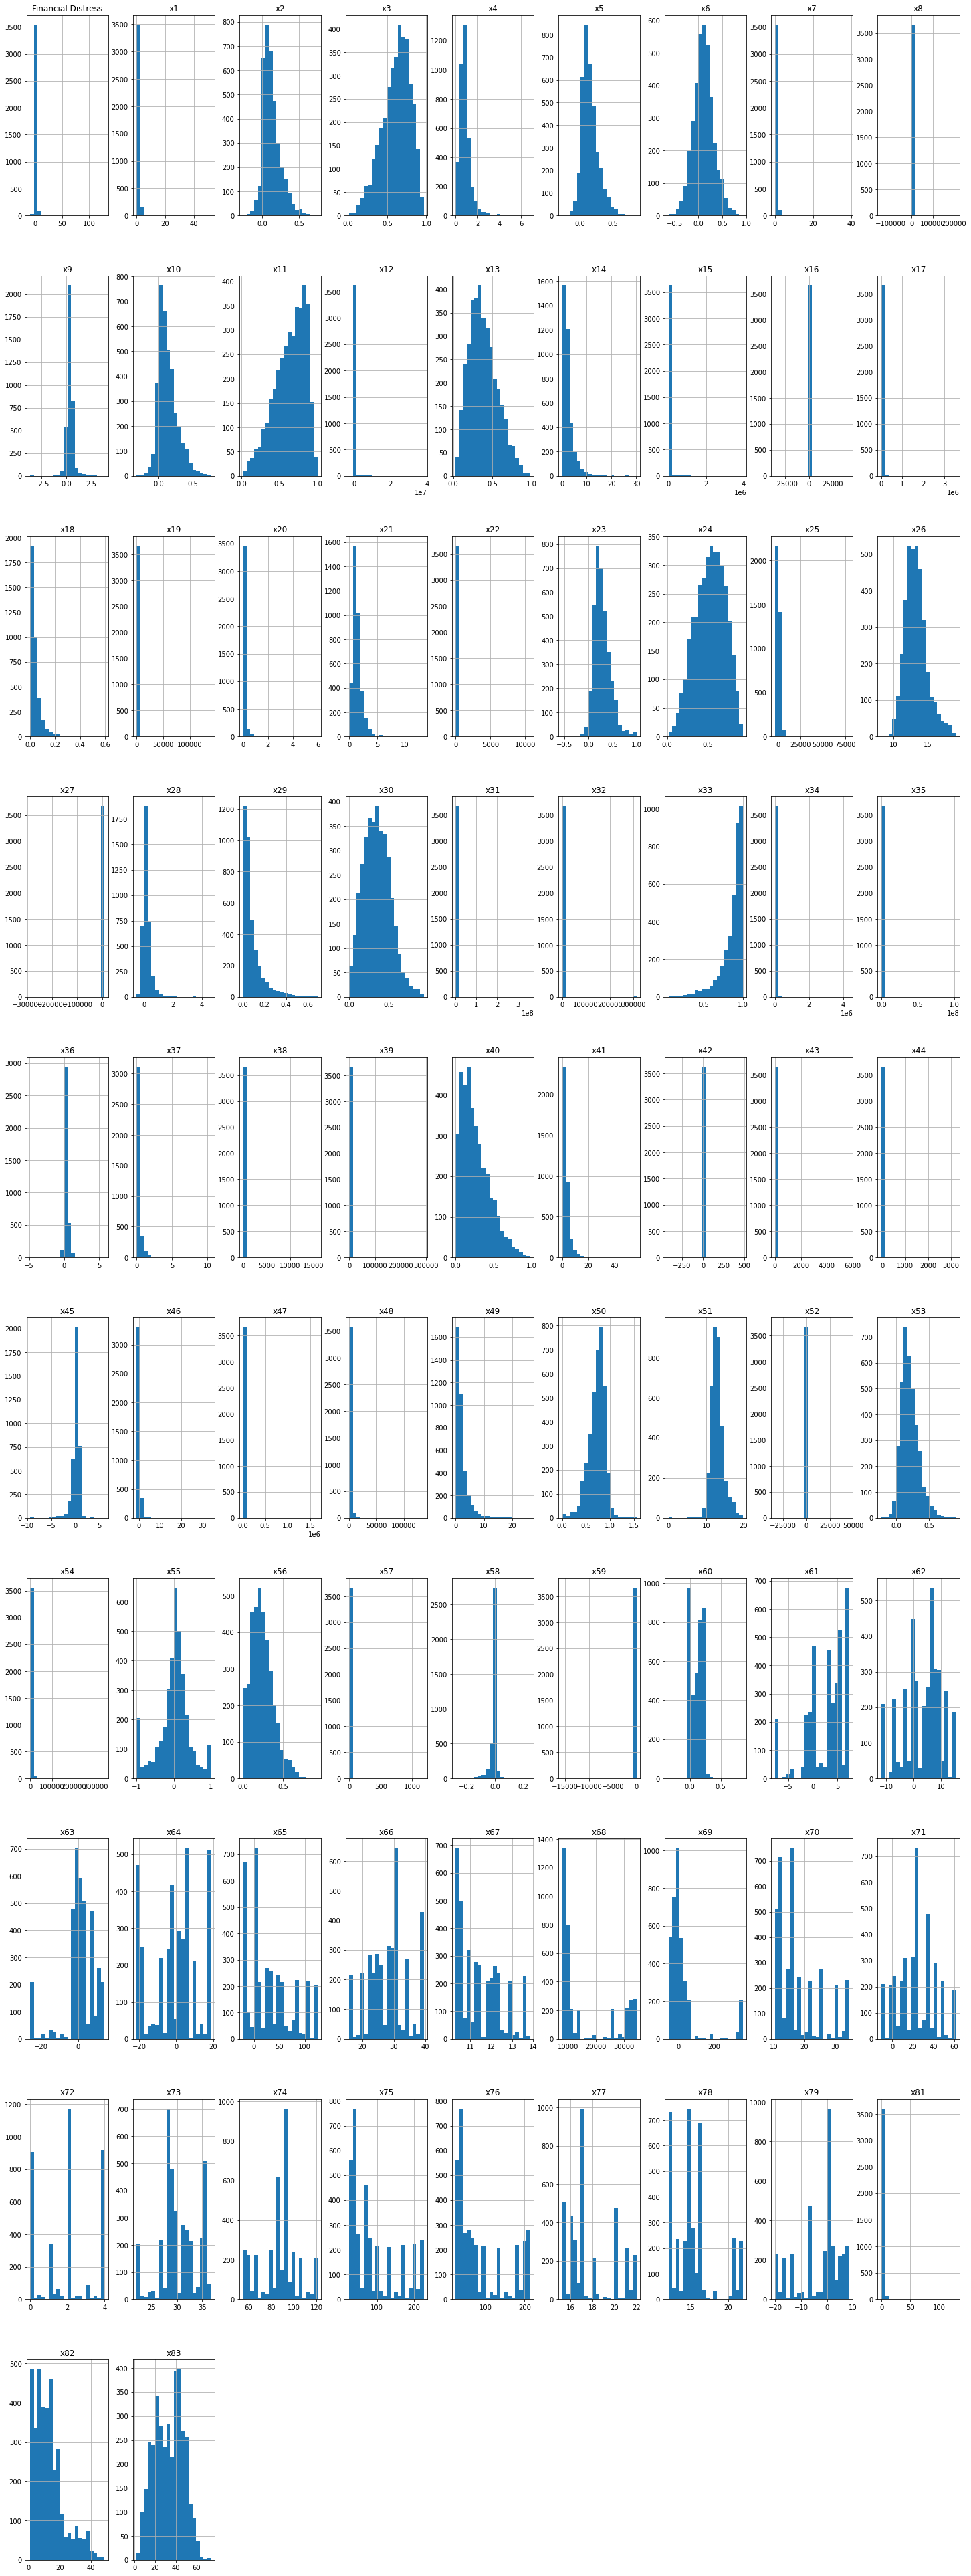

In [ ]:
df1.hist(figsize=(25,70), bins = 20);  #plotting Histogram

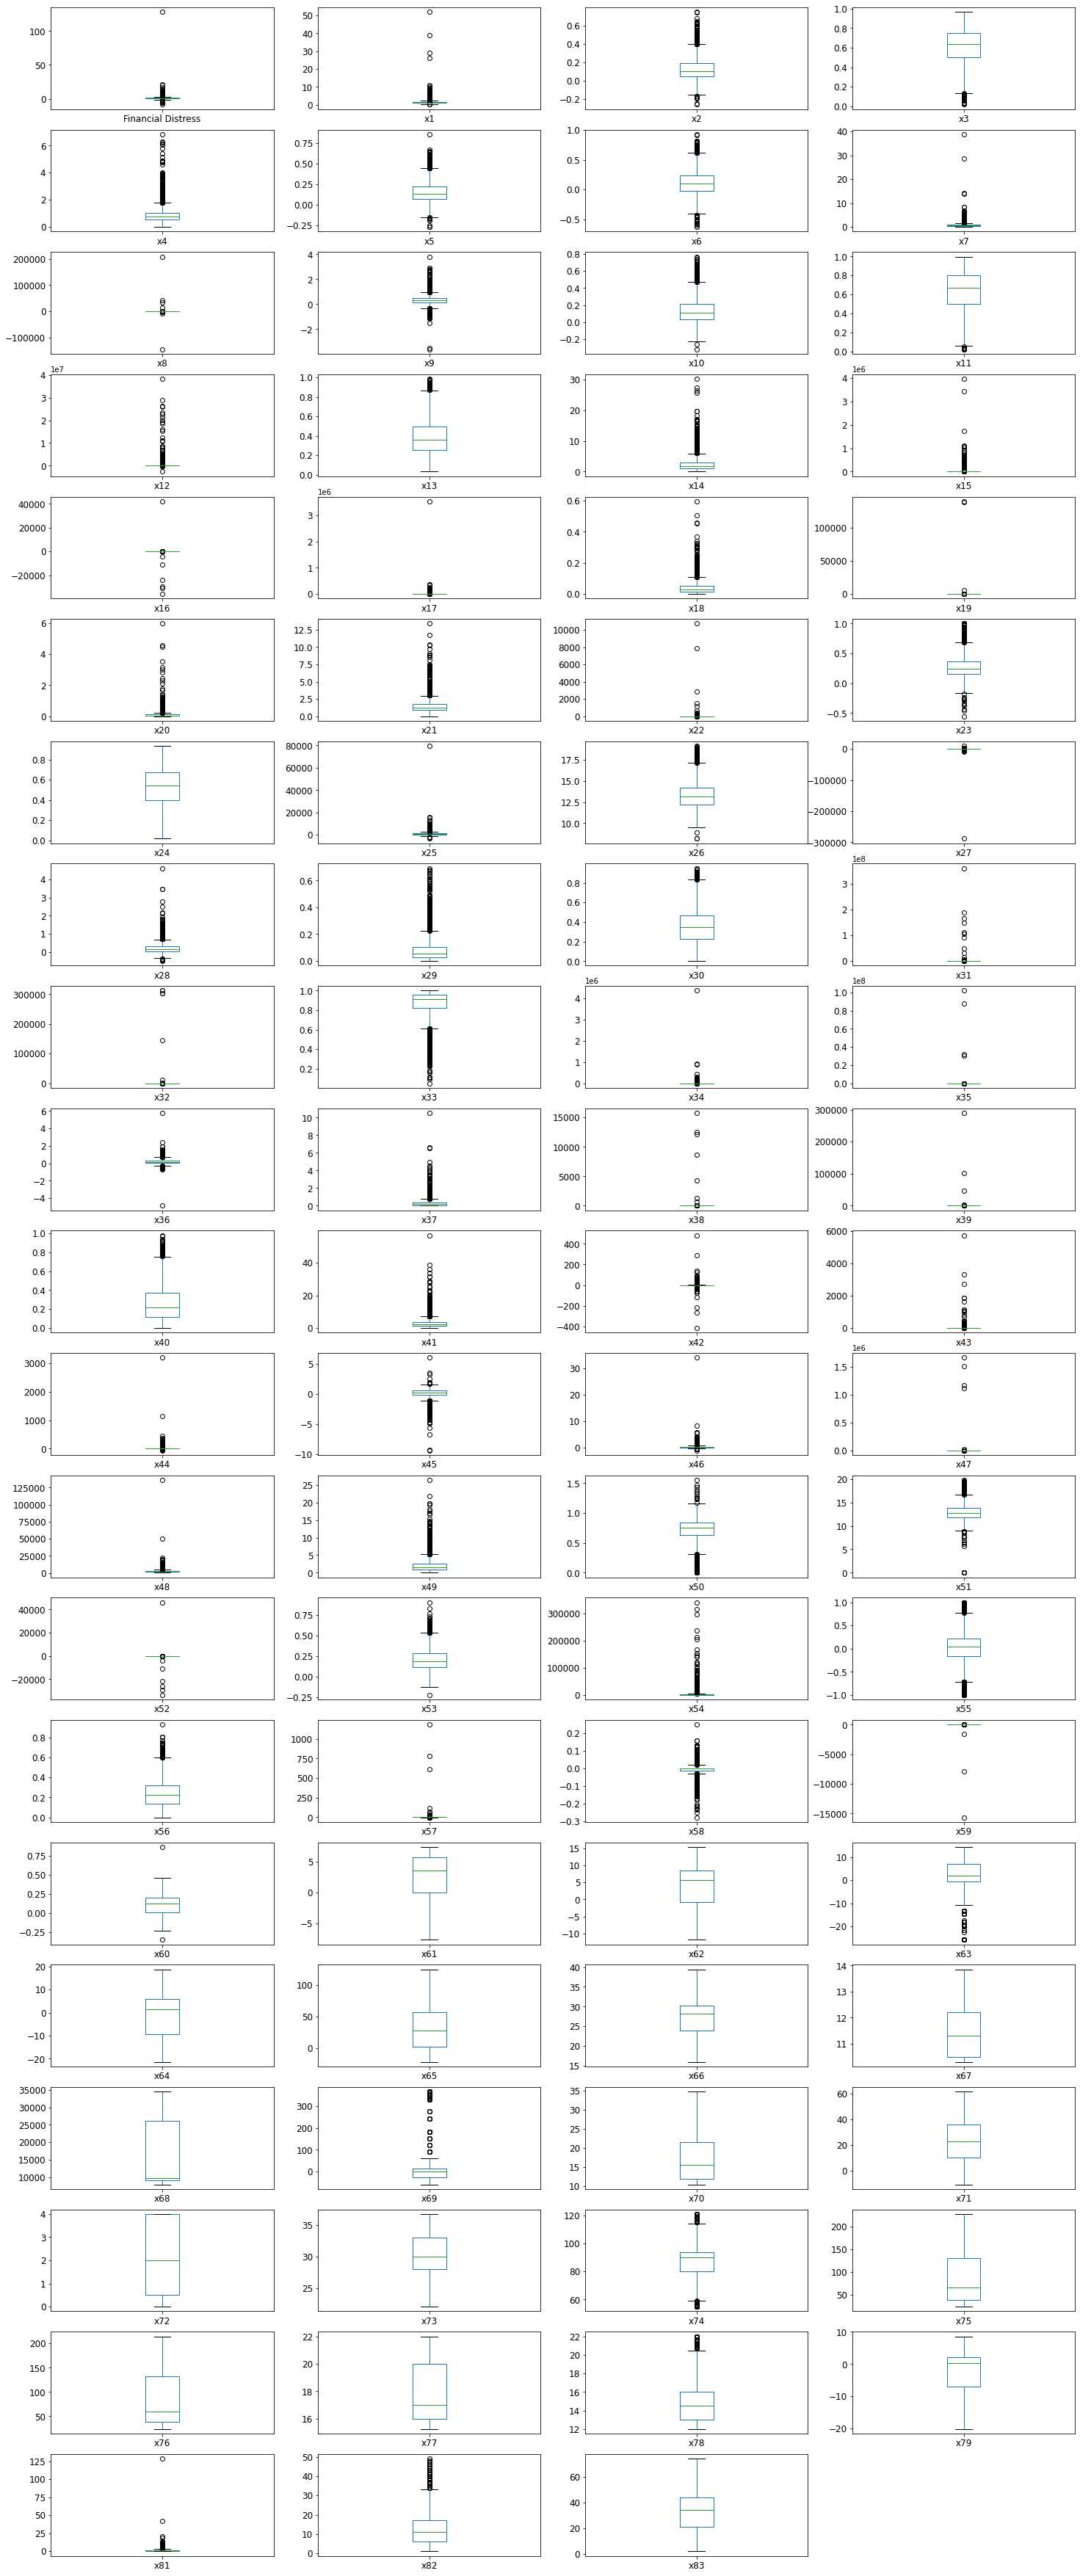

In [ ]:
df1.plot(kind='box', subplots=True, layout=(23,4), sharex=False, sharey=False, fontsize= 12, figsize = (25, 70))
plt.show()  #plotting boxplot



```
Observation
```
1) Some features are heavily skewed(x7 : 21.014,  x8 : 21.162,x17: 55,49), in both directions (x27 is negatively skewed : -60.32).

2) There are very large max values, which are much larger than the interquartile range, and these may need to be removed. 

observation

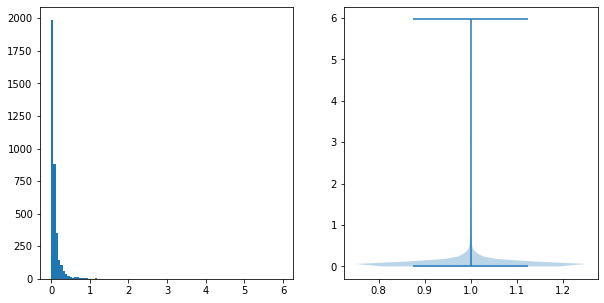

In [12]:
def plot_feature(df, clmn_name):
  '''Function for generating plots for a given Feature given df and column_name'''
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  df[clmn_name].hist(bins = 100, grid = False)
  plt.subplot(122)
  plt.violinplot(df[clmn_name])
  plt.show()
plot_feature(df1, 'x20')  




# Replacing Outliers with Mean




In [13]:
Q1=df1.quantile(q=0.25)                      
Q3=df1.quantile(q=0.75)
IQR= Q3-Q1

fd = df[['Financial Distress']] #
Q1fd=fd.quantile(q=0.25)                      
Q3fd=fd.quantile(q=0.75)
IQRfd= Q3fd-Q1fd

df_fd = fd[(fd >=(Q1fd-3*IQRfd))& (fd <= Q3fd+3*IQRfd)]  
df_inp = df1[(df1 >=(Q1-1.5*IQR))& (df1 <= Q3+1.5*IQR)]
df_inp=df_inp.iloc[:, 1:]
df_imp =  pd.concat([df_fd, df_inp], axis=1)

imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
imp_mean.fit(df_imp)
df_imp = pd.DataFrame(imp_mean.transform(df_imp))
col = df1.columns
df_imp.columns = col

df_imp

Financial Distress      x1        x2       x3  ...   x79       x81   x82   x83
0               0.010636  1.2810  0.022934  0.87454  ...   0.2  0.060390  30.0  49.0
1              -0.455970  1.2700  0.006454  0.82067  ...   0.4  0.010636  31.0  50.0
2              -0.325390  1.0529 -0.059379  0.92242  ...  -0.2 -0.455970  32.0  51.0
3              -0.566570  1.1131 -0.015229  0.85888  ...   5.6 -0.325390  33.0  52.0
4               1.357300  1.0623  0.107020  0.81460  ...   0.2  1.251000   7.0  27.0
...                  ...     ...       ...      ...  ...   ...       ...   ...   ...
3667            0.438020  2.2605  0.202890  0.16037  ...  -7.0  0.436380   4.0  41.0
3668            0.482410  1.9615  0.216440  0.20095  ... -16.0  0.438020   5.0  42.0
3669            0.500770  1.7099  0.207970  0.26136  ... -20.2  0.482410   6.0  43.0
3670            0.611030  1.5590  0.185450  0.30728  ...   6.4  0.500770   7.0  44.0
3671            0.518650  1.6148  0.176760  0.36369  ...   8.6  0.611030   8.0  45.0

[3672 rows x 83 columns]



```
Imputing Nan i.e outliers with mean value 
```



In [14]:
df_imp.isna().values.any()

False



```
Checking If all Nan were replaced
```



In [15]:
scaler=StandardScaler()
df_scal = copy.deepcopy(df_imp)
df_scal = df_scal.iloc[:, 1:]

model = scaler.fit(df_scal)
scaled_data= pd.DataFrame(model.transform(df_scal))   
scaled_data.columns= df_scal.columns

df_findis = df_imp[['Financial Distress']]
df_final =  pd.concat([df_findis, scaled_data], axis =1)

In [16]:
df_final # Standardized data

Financial Distress        x1        x2  ...       x81       x82       x83
0               0.010636  0.241328 -0.967909  ... -0.912197  2.539304  1.163525
1              -0.455970  0.212837 -1.133603  ... -0.979007  2.677678  1.236450
2              -0.325390 -0.349479 -1.795513  ... -1.605577  2.816052  1.309375
3              -0.566570 -0.193554 -1.351613  ... -1.430231  2.954426  1.382300
4               1.357300 -0.325132 -0.122479  ...  0.686581 -0.643297 -0.440828
...                  ...       ...       ...  ...       ...       ...       ...
3667            0.438020  2.778357  0.841431  ... -0.407309 -1.058419  0.580124
3668            0.482410  2.003909  0.977667  ... -0.405107 -0.920045  0.653049
3669            0.500770  1.352234  0.892507  ... -0.345499 -0.781671  0.725974
3670            0.611030  0.961383  0.666083  ... -0.320844 -0.643297  0.798899
3671            0.518650  1.105913  0.578711  ... -0.172785 -0.504923  0.871825

[3672 rows x 83 columns]

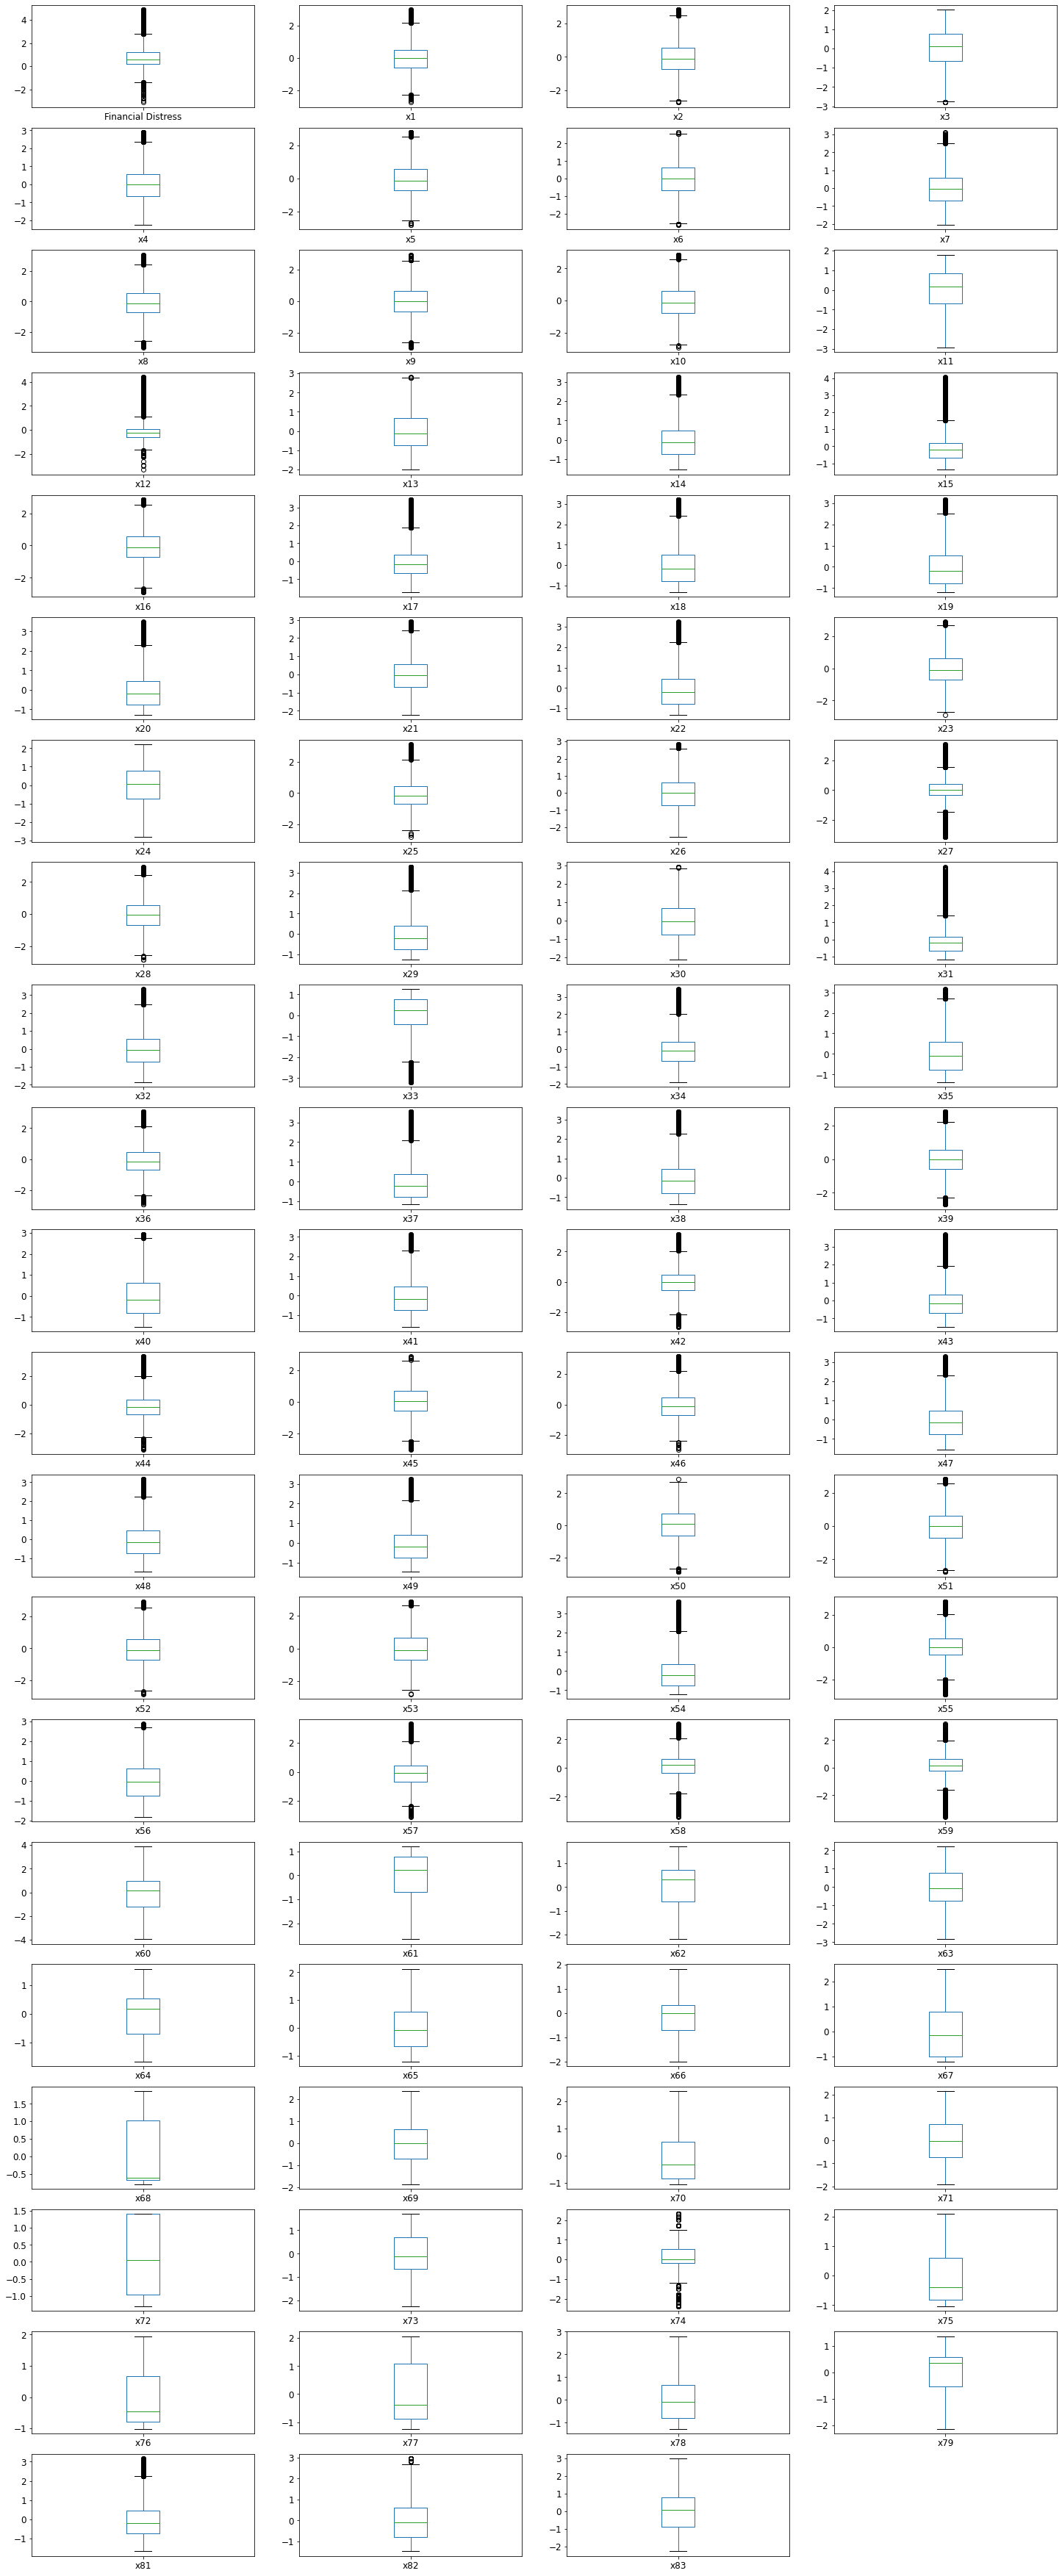

In [17]:
df_final.plot(kind='box', subplots=True, layout=(23,4), sharex=False, sharey=False, fontsize= 12, figsize = (25, 70)); #boxplot 


We can see that some columns consistently seem to have standardized. We have not standardized financial distress column since we need to have original values to comapare and see if company is in Financial Distress. 





In [18]:
display(desc_stats(df_final), desc_stats(df1))

Financial Distress            x1  ...           x82           x83
count            3672.000000  3.672000e+03  ...  3.672000e+03  3.672000e+03
mean                0.833895  7.262407e-16  ... -3.402023e-16  2.929755e-17
std                 1.057821  1.000136e+00  ...  1.000136e+00  1.000136e+00
min                -3.140000 -2.751044e+00  ... -1.473541e+00 -2.263956e+00
25%                 0.177420 -6.075142e-01  ... -7.816713e-01 -8.783783e-01
50%                 0.590045 -1.043187e-02  ... -8.980140e-02  6.964826e-02
75%                 1.224225  5.090179e-01  ...  6.020685e-01  7.988995e-01
max                 4.887800  2.974948e+00  ...  2.954426e+00  2.986653e+00
skewness            1.078923  4.437920e-01  ...  7.960057e-01 -2.381237e-02
kurtosis            2.100514  3.869968e-01  ...  4.118171e-01 -9.241602e-01

[10 rows x 83 columns]

Financial Distress           x1  ...          x82          x83
count            3672.000000  3672.000000  ...  3672.000000  3672.000000
mean                1.040257     1.387820  ...    13.122277    33.044935
std                 2.652227     1.452926  ...     9.465907    13.714563
min                -8.631700     0.075170  ...     1.000000     2.000000
25%                 0.172275     0.952145  ...     6.000000    21.000000
50%                 0.583805     1.183600  ...    11.000000    34.000000
75%                 1.351750     1.506475  ...    17.000000    44.000000
max               128.400000    51.954000  ...    49.000000    74.000000
skewness           30.873600    20.058157  ...     1.156911    -0.023812
kurtosis         1451.206671   579.289645  ...     1.039430    -0.924160

[10 rows x 83 columns]



```
As we can observe there are Outliers and they need to be removed
```



In [19]:
df_final.isnull().values.any() # Checking if there are any null values for the scaled data

False

In [20]:
scaled_fd = df_final[['Financial Distress']]
df_final = df_final.iloc[:, 1:]
Q1=df_final.quantile(q=0.25)                       #filtering outliers
Q3=df_final.quantile(q=0.75)
IQR= Q3-Q1

#list(zip(Q1-1.5*IQR, Q3+1.5*IQR))
df_scaled = df_final[(scaled_data >=(Q1-1.5*IQR))& (scaled_data <= Q3+1.5*IQR)]
#scaled_data=scaled_data[   (scaled_data<=(Q3+(1.5*IQR)))     ]
df_scal = pd.concat([scaled_fd, df_scaled], axis =1)
#scaled_data.isna().values.any()
#scaled_data[(scaled_data == np.nan)]
#scaled_data


In [21]:
df_scal

Financial Distress        x1        x2  ...       x81       x82       x83
0               0.010636  0.241328 -0.967909  ... -0.912197  2.539304  1.163525
1              -0.455970  0.212837 -1.133603  ... -0.979007  2.677678  1.236450
2              -0.325390 -0.349479 -1.795513  ... -1.605577       NaN  1.309375
3              -0.566570 -0.193554 -1.351613  ... -1.430231       NaN  1.382300
4               1.357300 -0.325132 -0.122479  ...  0.686581 -0.643297 -0.440828
...                  ...       ...       ...  ...       ...       ...       ...
3667            0.438020       NaN  0.841431  ... -0.407309 -1.058419  0.580124
3668            0.482410  2.003909  0.977667  ... -0.405107 -0.920045  0.653049
3669            0.500770  1.352234  0.892507  ... -0.345499 -0.781671  0.725974
3670            0.611030  0.961383  0.666083  ... -0.320844 -0.643297  0.798899
3671            0.518650  1.105913  0.578711  ... -0.172785 -0.504923  0.871825

[3672 rows x 83 columns]

In [22]:
desc_stats(df_scal)  #descriptive statistics of cleaned data

Financial Distress           x1  ...          x82           x83
count            3672.000000  3522.000000  ...  3614.000000  3.672000e+03
mean                0.833895    -0.073255  ...    -0.046304  2.929755e-17
std                 1.057821     0.873570  ...     0.938335  1.000136e+00
min                -3.140000    -2.275497  ...    -1.473541 -2.263956e+00
25%                 0.177420    -0.618684  ...    -0.781671 -8.783783e-01
50%                 0.590045    -0.043456  ...    -0.089801  6.964826e-02
75%                 1.224225     0.418234  ...     0.463695  7.988995e-01
max                 4.887800     2.183405  ...     2.677678  2.986653e+00
skewness            1.078923     0.193402  ...     0.659842 -2.381237e-02
kurtosis            2.100514    -0.049634  ...     0.148350 -9.241602e-01

[10 rows x 83 columns]



```
As we can see all outliers were removed except for Financial Distress
```



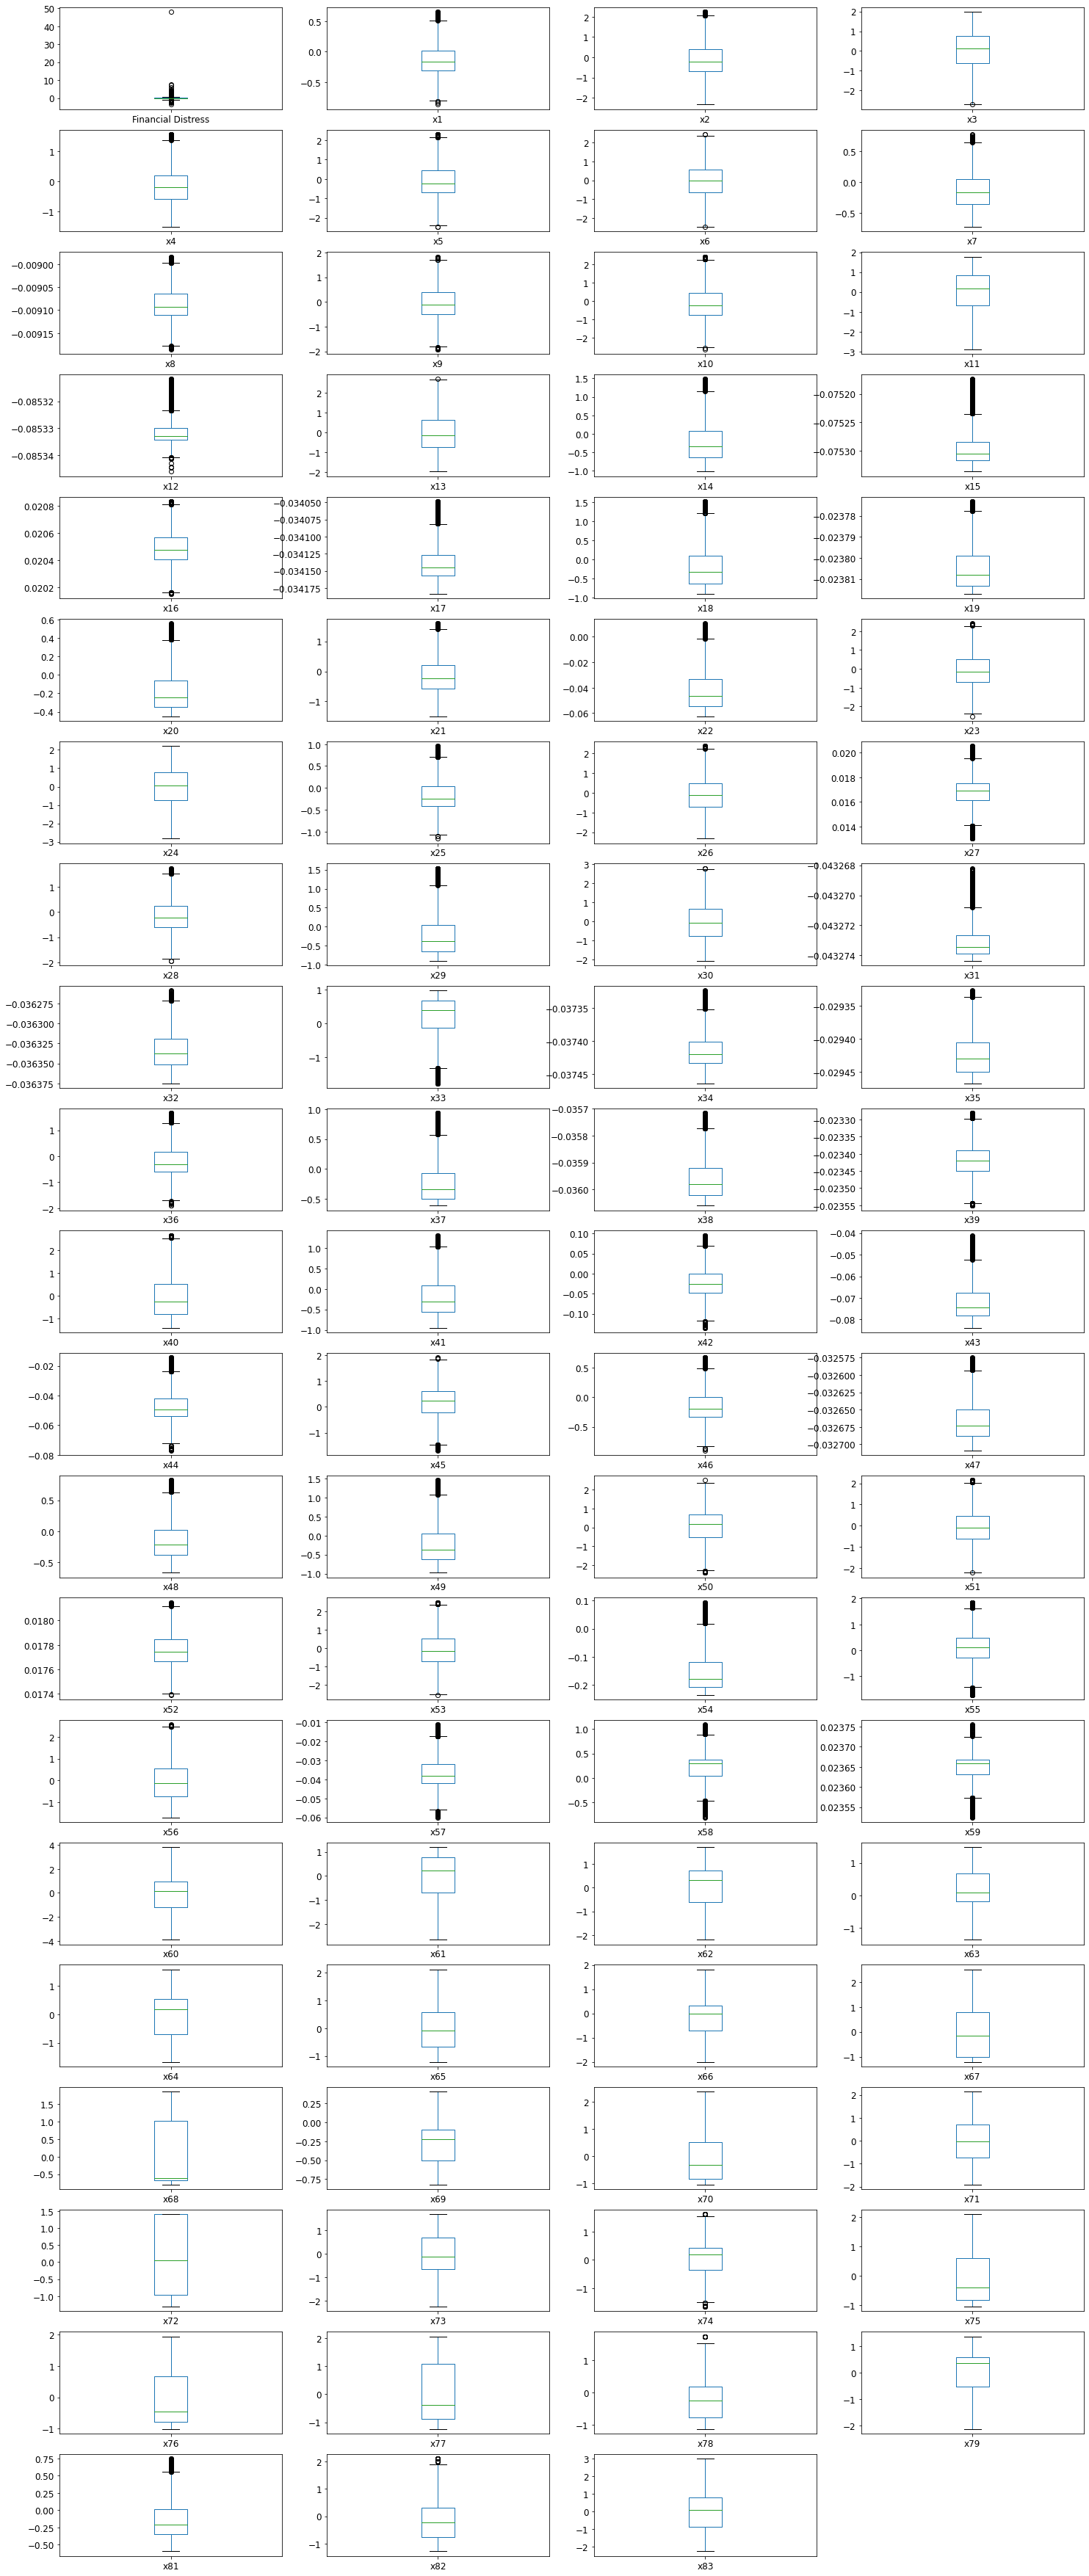

In [ ]:
df_scal.plot(kind='box', subplots=True, layout=(23,4), sharex=False, sharey=False, fontsize= 12, figsize = (25, 70))
plt.show()    #plotting boxplot to see If we were successful in removing outliers

## Data Visualization

In [ ]:
corr_df = df_scaled.corr()
corr_df = pd.DataFrame(corr_df)           
corr_fd = corr_df.iloc[0, :]
corr_fd[:]                             

x1     1.000000
x2     0.255700
x3    -0.456109
x4     0.182968
x5     0.217573
         ...   
x78   -0.029861
x79   -0.077668
x81    0.175361
x82    0.004850
x83   -0.051958
Name: x1, Length: 82, dtype: float64

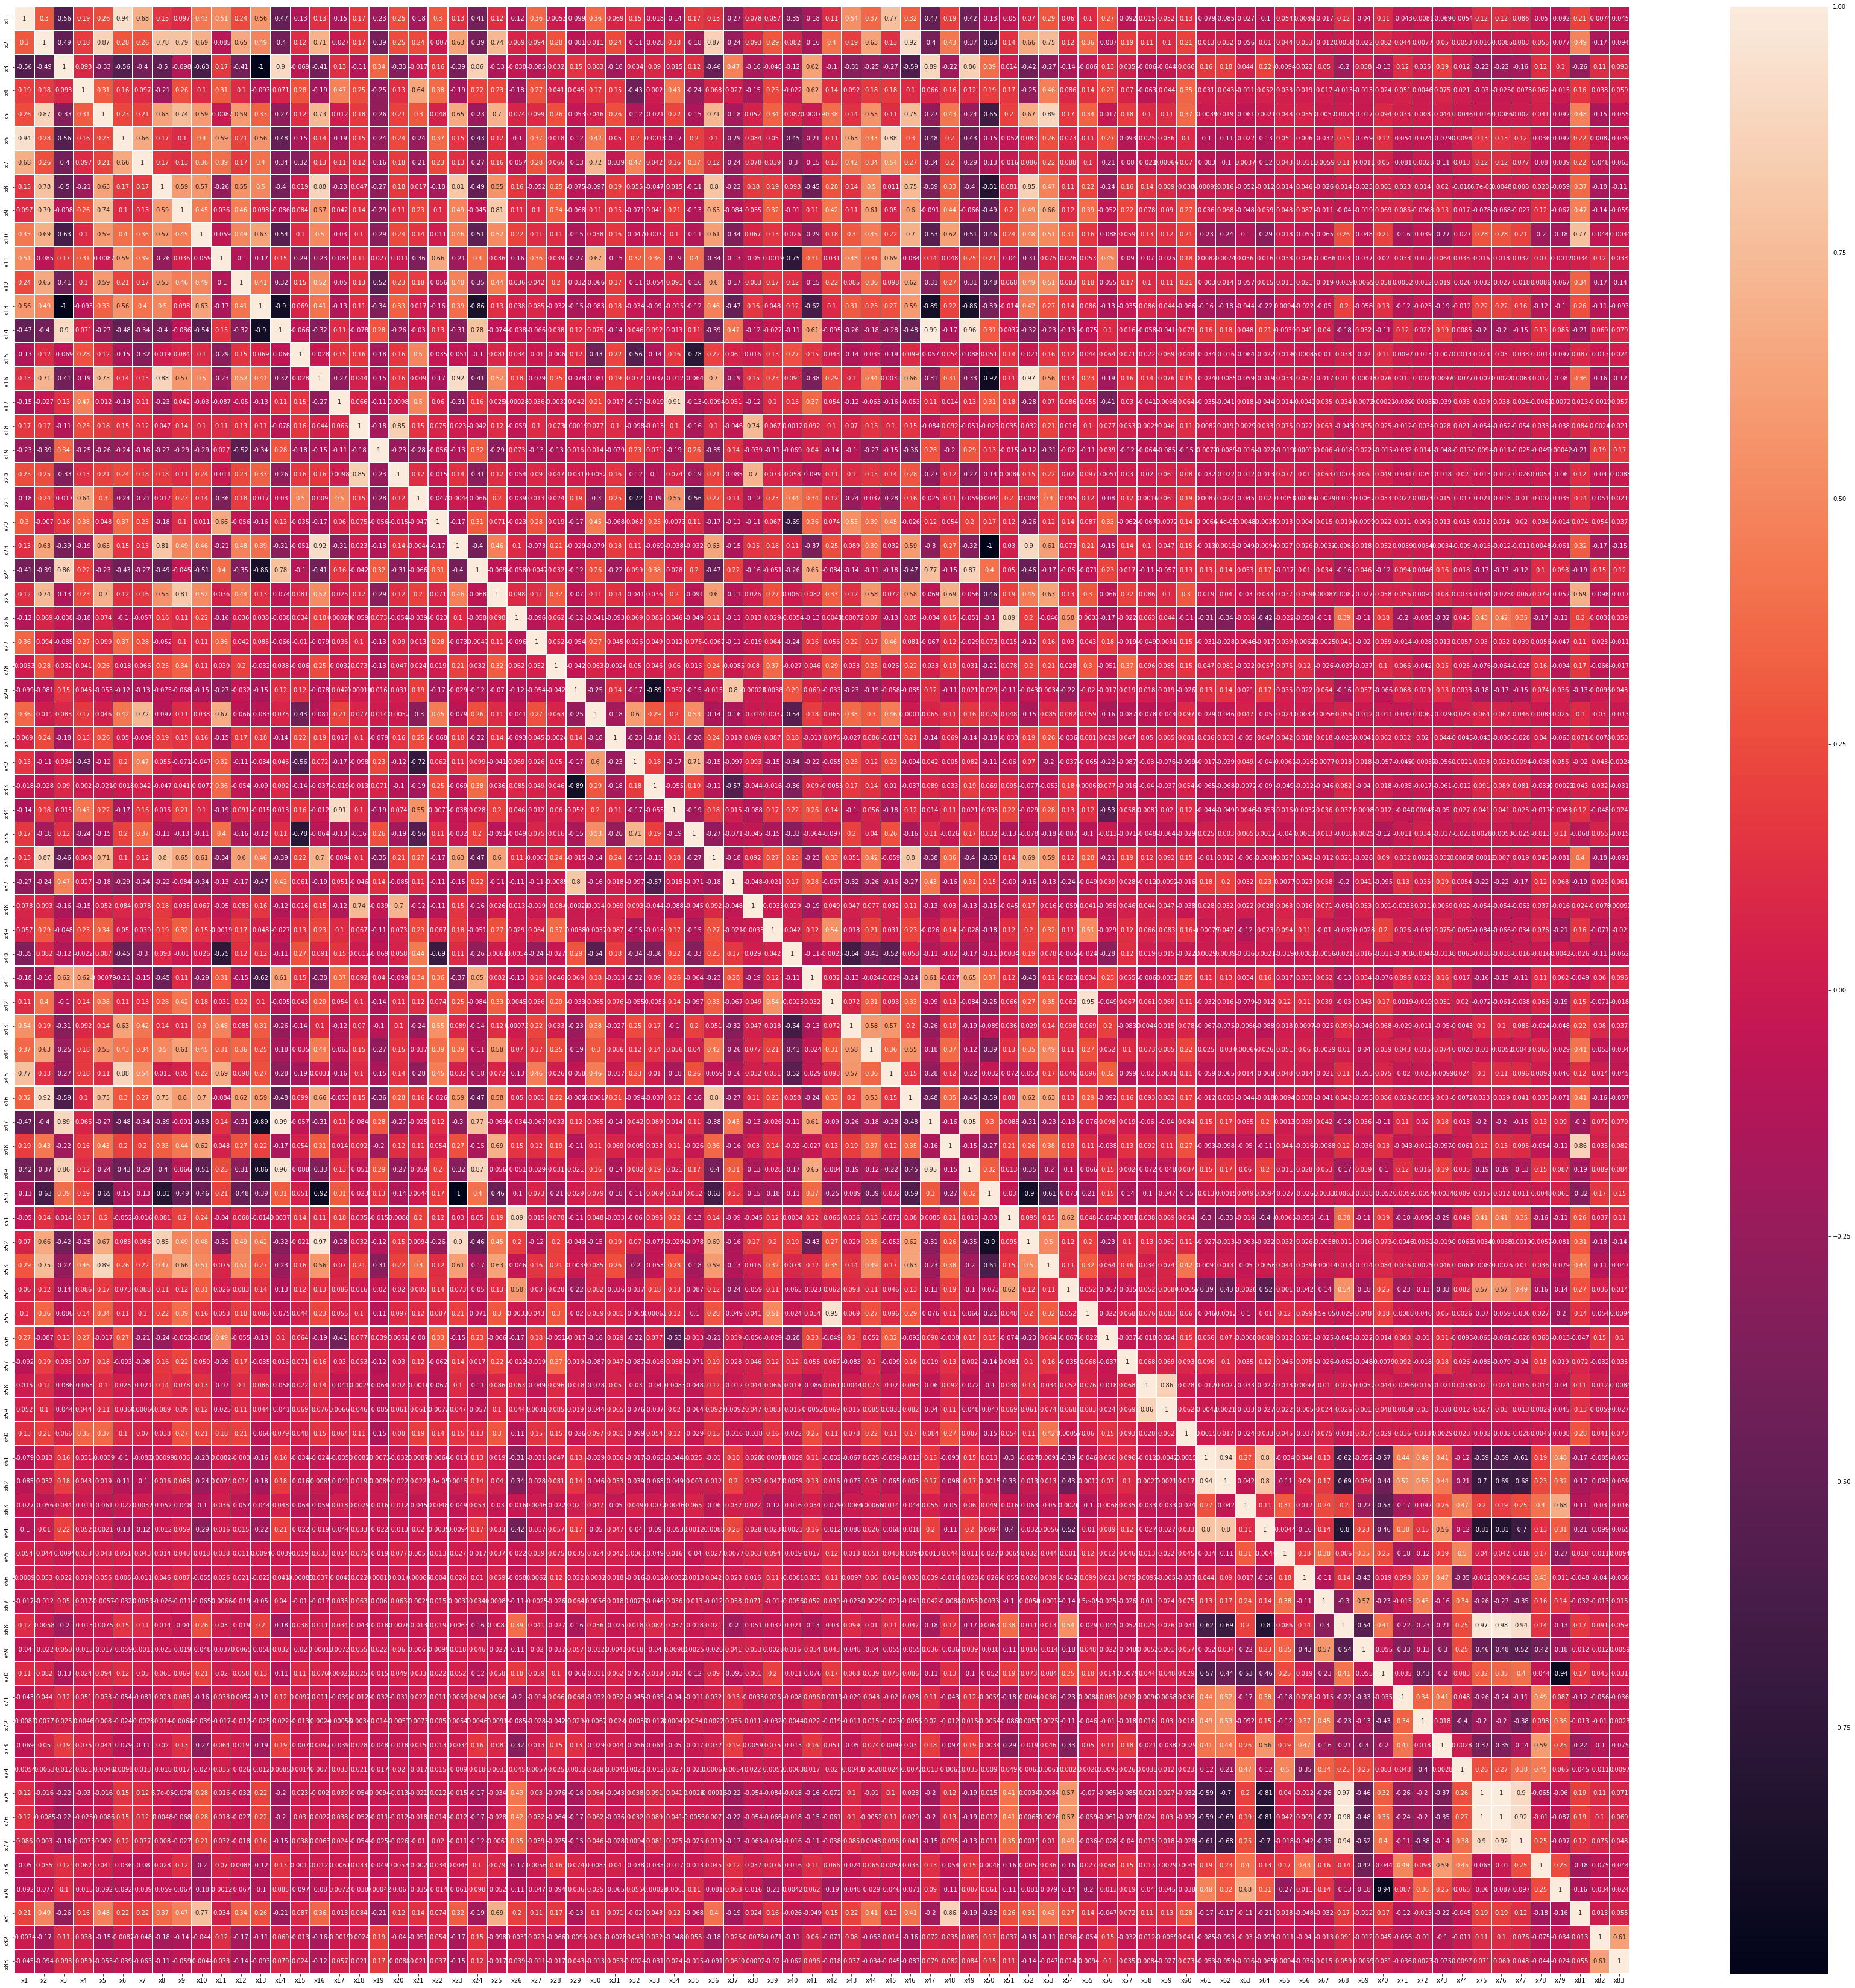

In [ ]:
fig,ax = plt.subplots(figsize = (60,60))      # Correlation Heat Map
ax = sns.heatmap(corr_df, annot=True, linewidths=0.5)

**Plotting Highly correlated Heatmap**

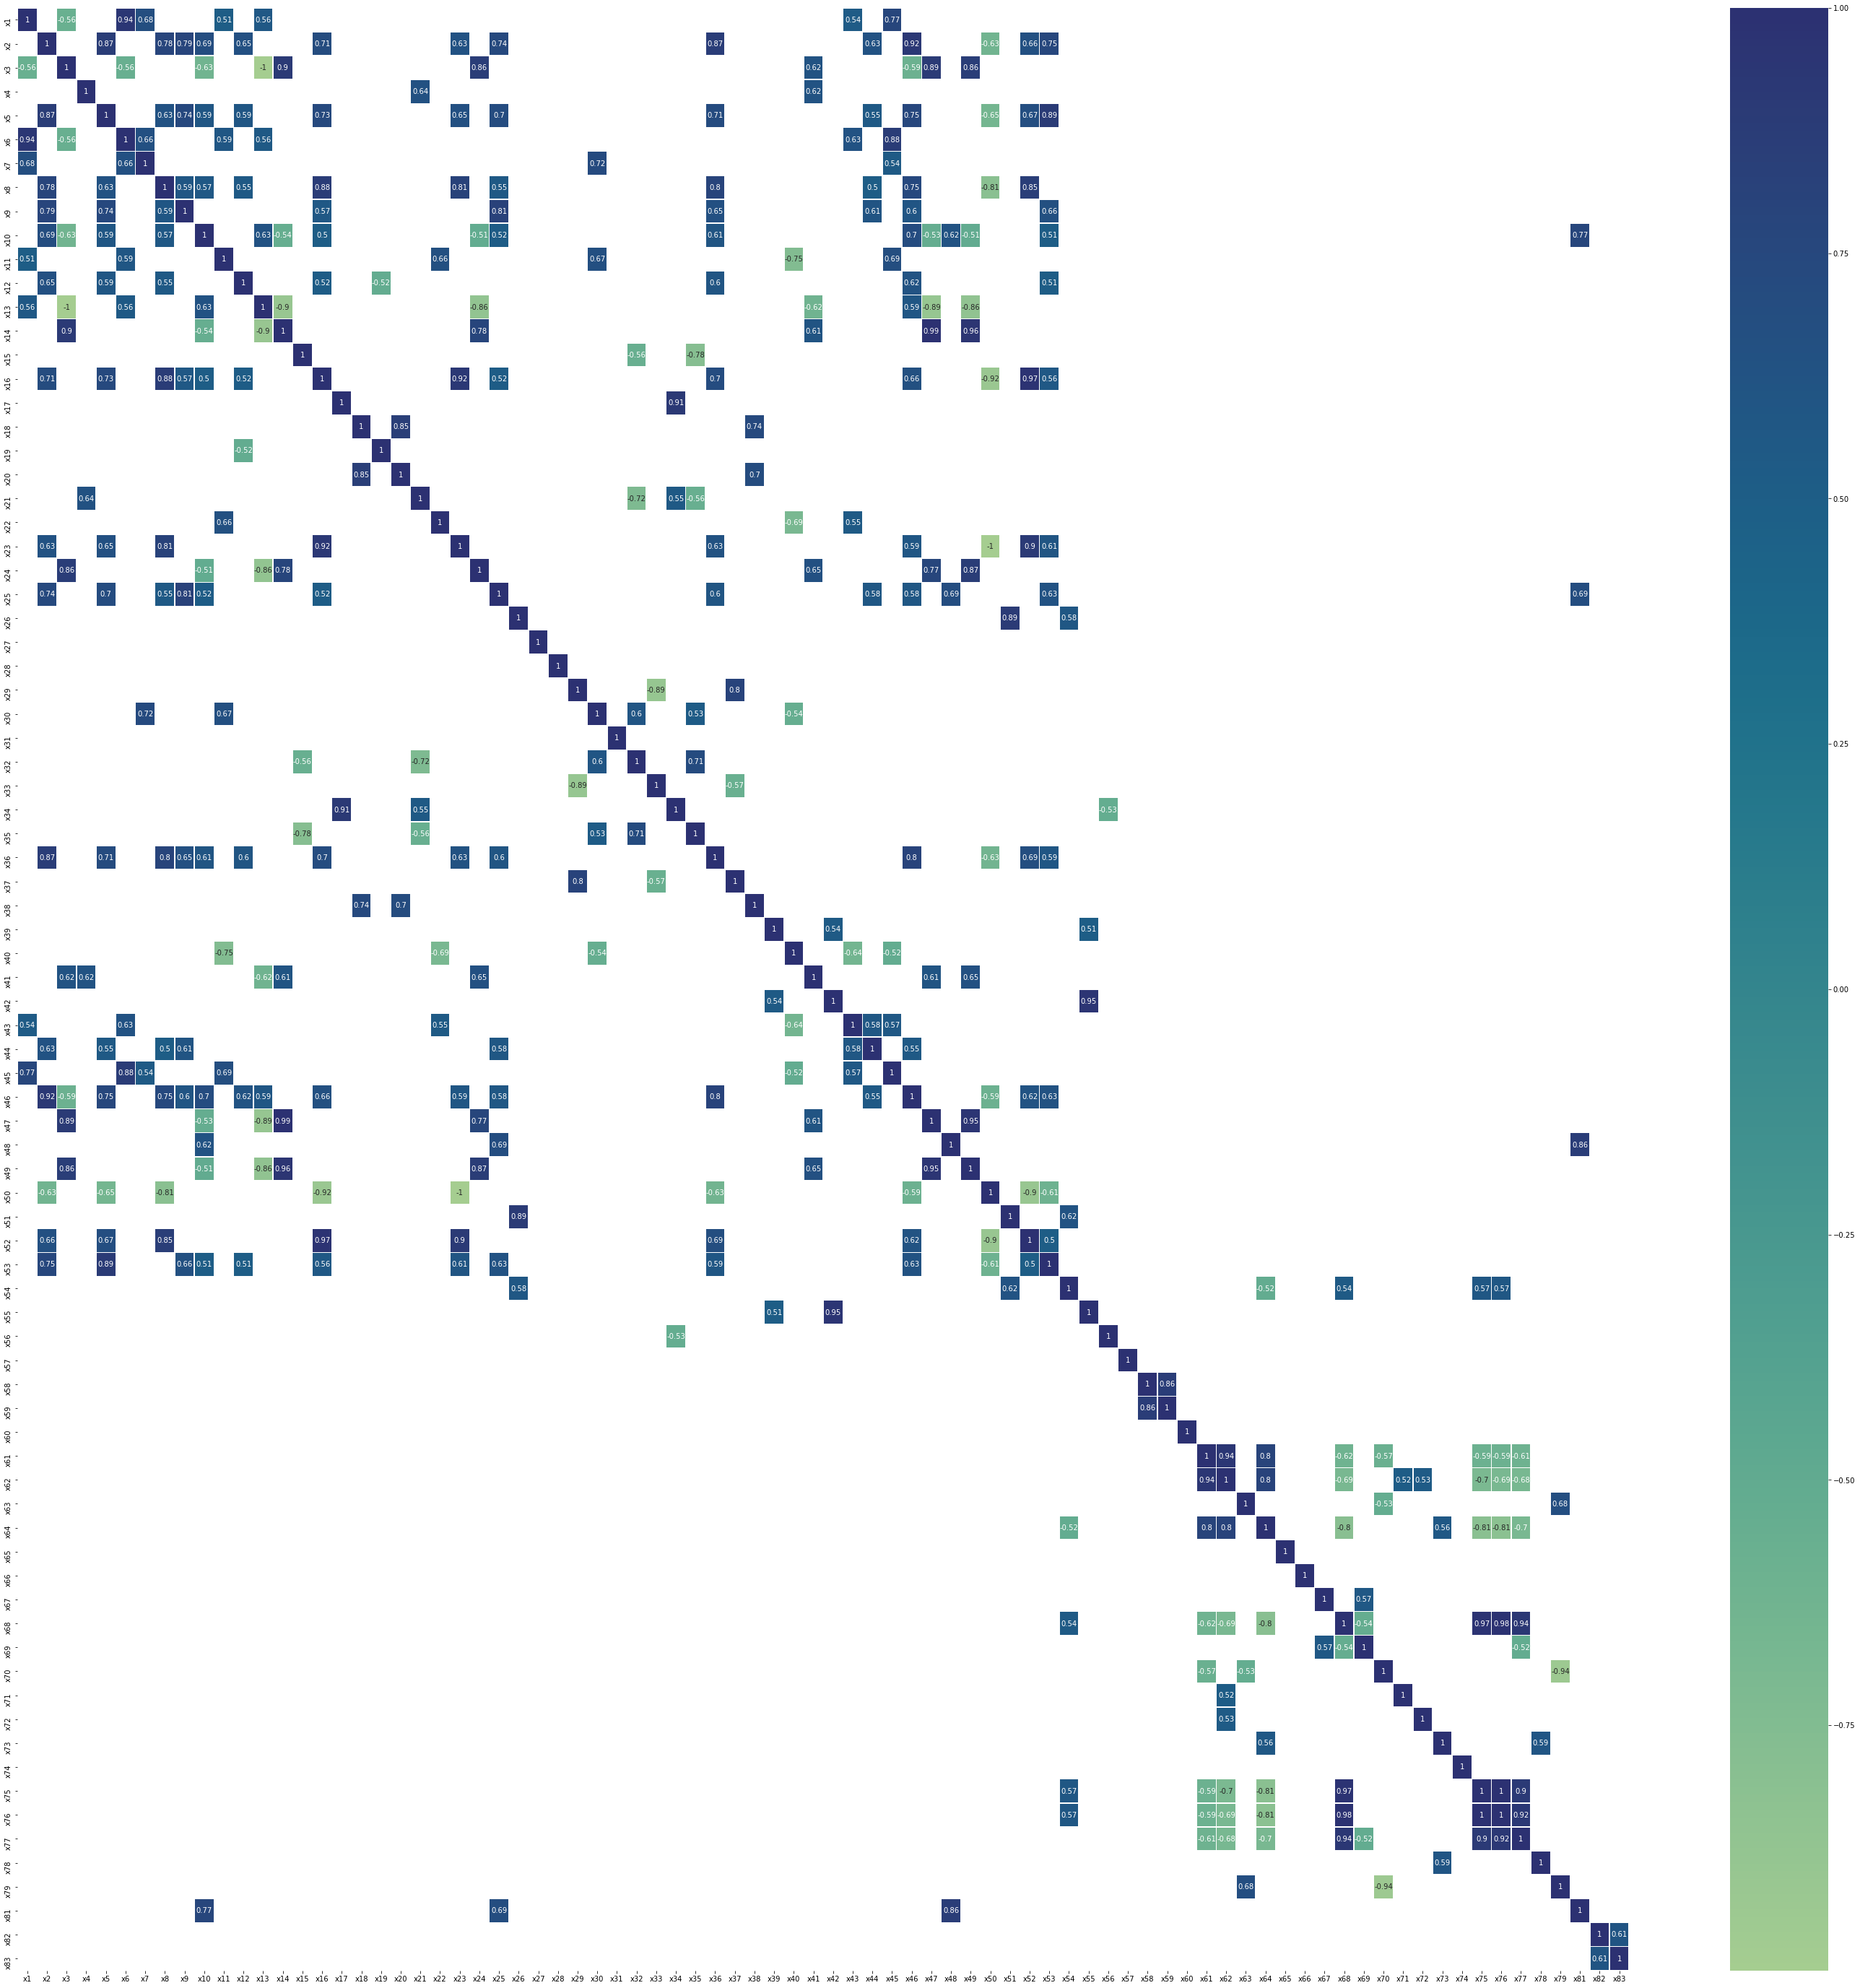

In [ ]:
plot_highcorrheatmap()  # plotting only features with corr > 0.5 and corr < -0.5


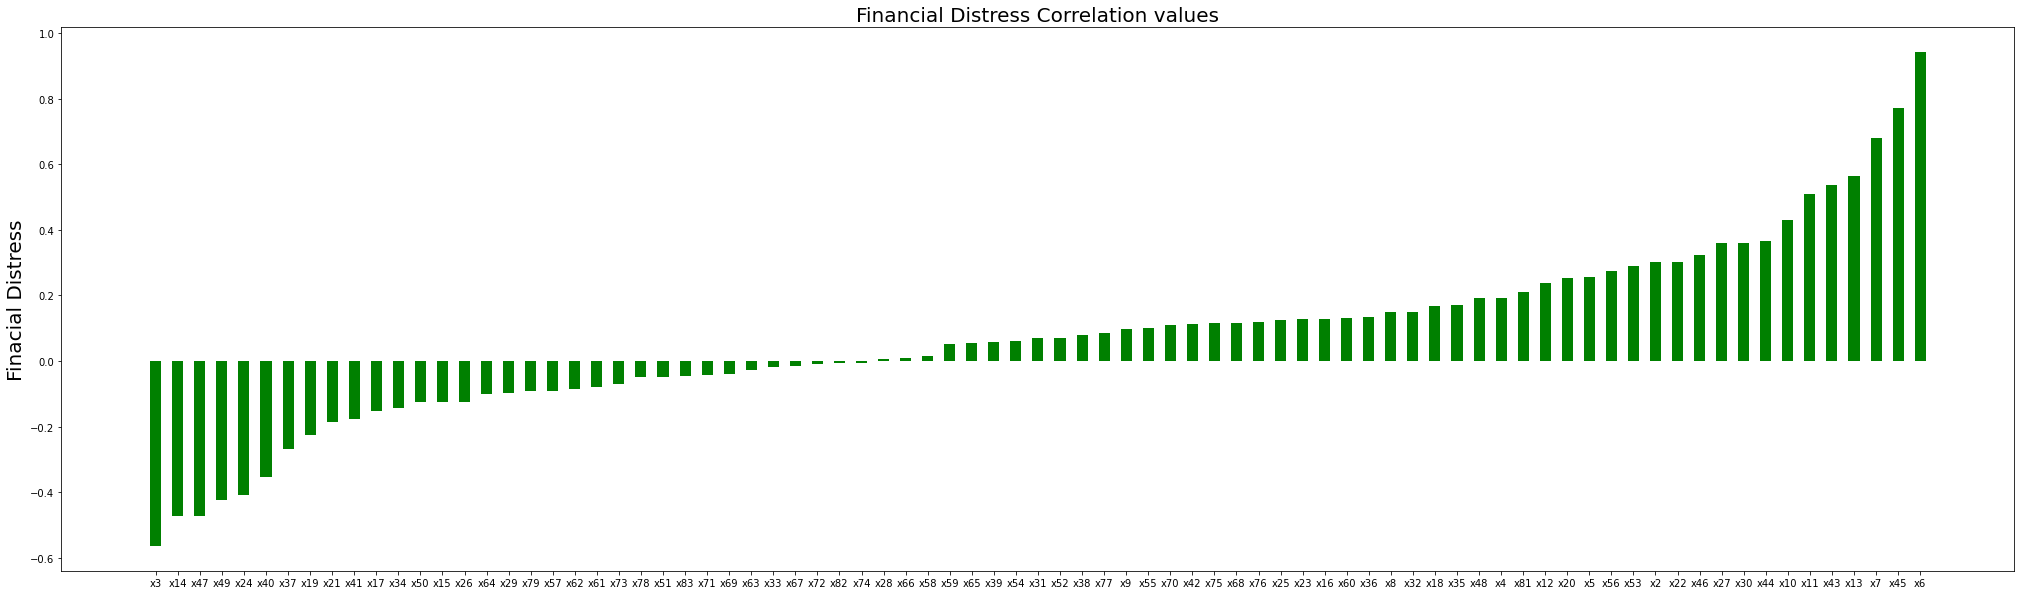

In [ ]:
plt.figure(figsize=(35,10))
plt.bar(corr_fd.sort_values().iloc[:-1].index, corr_fd.sort_values().iloc[:-1], width=0.5, align='center', color = 'g')
plt.ylabel(ylabel='Finacial Distress', size=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.title(label = 'Financial Distress Correlation values', size = 20)
plt.show()                           # barplot for correlation values for all features Ascending order



```
As we can see x48, x10, x81( corr > 0.5) and no values less than -0.5. we will use these features for visualizing financial distress.
```



In [ ]:
## positive correlation x81,10,x48,x25,x2,x5,x16,x9,x8,x53,x23,x44,x52,x36,x46,x12,x60,x54
## negative correlation x50,x3,x64,x37,x73,61,x24,x62,x29,x19,x49

In [ ]:

#corr_df.iloc[:3, :] ## [Row,column]-- Row0 is Financial Distress variable 
corr_GreaterThanPointFive=corr_df[(corr_df.iloc[:,:]>0.5) | (corr_df.iloc[:,:]<-0.5)]
corr_ColumnsGreaterThanPointFive=corr_GreaterThanPointFive.iloc[0].dropna()
corr_ColumnsGreaterThanPointFive
 
# got three features-x10,x48,x81

x1     1.000000
x3    -0.564565
x6     0.942111
x7     0.679715
x11    0.509479
x13    0.564564
x43    0.535984
x45    0.769863
Name: x1, dtype: float64

In [ ]:

corr = pd.DataFrame(corr_df[(corr_df>=0.5)|(corr_df<=-0.5)]) # Correlation dictionary for highly correlated values.
corr_dict = {}
for f in corr.index:
  corr_dict[f] = pd.DataFrame(corr.sort_values(f)[f].dropna())
      

In [ ]:
def plot_highcorrheatmap():
  '''Function to plot highly correlated values on heatmap i.e. >0.5 & <-0.5'''
  fig,ax = plt.subplots(figsize = (50,50))
  mask = corr.isnull()
  ax = sns.heatmap(corr, annot=True, linewidths=0.5, mask = mask, cmap = "crest")

Here is a condensed function with all the Data Preprocessing that we conducted on our data. 

Delete and change it to preprocessed_data function under functions heading

In [31]:
def processed_df(df):
    '''
    Function for getting cleaned and transformed data)
    '''
    #df = pd.read_csv('Financial Distress.csv')
    df1 = df.iloc[:, 3:]
    df1 = df1.drop('x80', axis =1)
    
    Q1=df1.quantile(q=0.25)                      
    Q3=df1.quantile(q=0.75)
    IQR= Q3-Q1
    
    fd = df[['Financial Distress']] #
    Q1fd=fd.quantile(q=0.25)                      
    Q3fd=fd.quantile(q=0.75)
    IQRfd= Q3fd-Q1fd

    df_fd = fd[(fd >=(Q1fd-3*IQRfd))& (fd <= Q3fd+3*IQRfd)]  


    df_inp = df1[(df1 >=(Q1-1.5*IQR))& (df1 <= Q3+1.5*IQR)]
    df_inp = pd.concat([df_fd, df_inp], axis =1)

    imp_mean= SimpleImputer(missing_values=np.nan,strategy='mean')
    imp_mean.fit(df_inp)
    df_imp = pd.DataFrame(imp_mean.transform(df_inp))
    col = df1.columns.insert(0, 'Financial Distress')
    df_imp.columns = col
    
    scaler=StandardScaler()
    df_scal = copy.deepcopy(df_imp)
    df_scal = df_scal.iloc[:, 1:]
    
    model = scaler.fit(df_scal)
    scaled_data= pd.DataFrame(model.transform(df_scal))   
    scaled_data.columns= df_scal.columns

    df_findis = df_imp[['Financial Distress']]
    df_final =  pd.concat([df_findis, scaled_data], axis =1)
    #   scaled_data = scaled_data.iloc[:, :]
    #scaled_data = pd.concat([scaled_fd, scaled_data], axis =1)
    
    return df_final

In [32]:
def get_corr(df ,pos, neg):
  

  corr_df = df.corr()
  corr_df = pd.DataFrame(corr_df)
  fd_corr = corr_df.iloc[0, :] 

  corr = pd.DataFrame(corr_df[(corr_df>=pos)|(corr_df<= neg)])
  corr_dict = {}
  for f in corr.index:
    corr_dict[f] = pd.DataFrame(corr.sort_values(f)[f].dropna())
  return corr_df, fd_corr, corr_dict
  

In [33]:
df = processed_df(df)
corr_df, fd_corr, highcorr_dict = get_corr(df , 0.5, -0.5)

In [34]:
df

Financial Distress        x1        x2  ...       x81       x82       x83
0               0.010636  0.241328 -0.967909  ... -0.912197  2.539304  1.163525
1              -0.455970  0.212837 -1.133603  ... -0.979007  2.677678  1.236450
2              -0.325390 -0.349479 -1.795513  ... -1.605577  2.816052  1.309375
3              -0.566570 -0.193554 -1.351613  ... -1.430231  2.954426  1.382300
4               1.357300 -0.325132 -0.122479  ...  0.686581 -0.643297 -0.440828
...                  ...       ...       ...  ...       ...       ...       ...
3667            0.438020  2.778357  0.841431  ... -0.407309 -1.058419  0.580124
3668            0.482410  2.003909  0.977667  ... -0.405107 -0.920045  0.653049
3669            0.500770  1.352234  0.892507  ... -0.345499 -0.781671  0.725974
3670            0.611030  0.961383  0.666083  ... -0.320844 -0.643297  0.798899
3671            0.518650  1.105913  0.578711  ... -0.172785 -0.504923  0.871825

[3672 rows x 83 columns]

In [35]:
fd_corr
highcorr_dict['Financial Distress']            

Financial Distress
x25                           0.519829
x10                           0.586401
x48                           0.592648
x81                           0.610939
Financial Distress            1.000000

In [37]:
lst = []
for feat in highcorr_dict['Financial Distress'].index:
  coef, p_val = stats.pearsonr(df['Financial Distress'], df[feat])
  lst.append([coef, p_val])   
lst = pd.DataFrame(lst)
lst.columns = ['coef', 'p-value']        #Checking If the values are statistically significant
lst

coef        p-value
0  0.519829  2.280291e-253
1  0.586401   0.000000e+00
2  0.592648   0.000000e+00
3  0.610939   0.000000e+00
4  1.000000   0.000000e+00

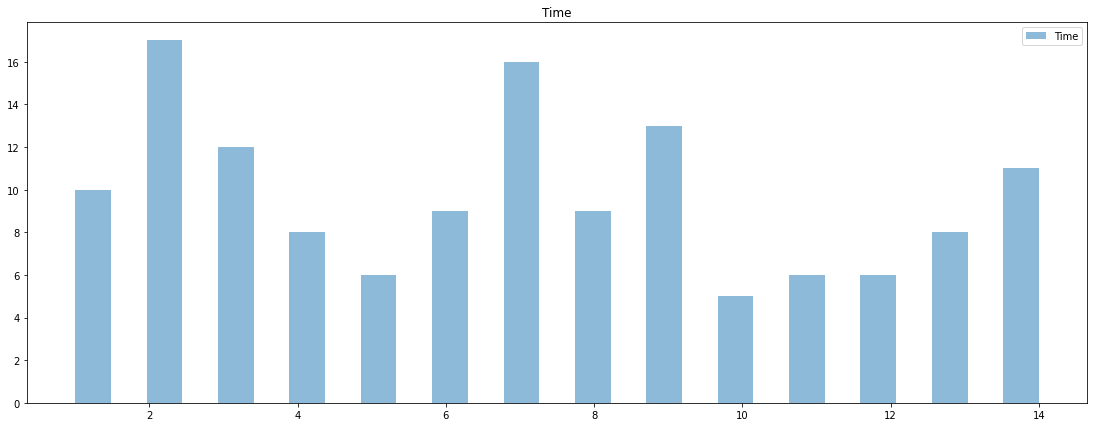

In [36]:
df_fortime = pd.read_csv('/content/Financial Distress.csv')
df_time = pd.DataFrame(df_fortime, columns= ['Time', 'Financial Distress'])
df_time['Financial Distress'] = df_time['Financial Distress'].apply(lambda X : 1 if X < -0.5 else 0 )
df_new = df_time.loc[df_time['Financial Distress'] == 1]
df_new.hist(column='Time',bins=27, alpha=0.5,figsize = (19,7), legend = True, grid = False);

ylabel = No of Companies in Fiancial Distress, xlabel = Time Periods

use preprocessed data for the below plot

In [38]:


df_scatter = pd.DataFrame(df, columns=['x25','x48','x81','Financial Distress'])
df_scatter['Financial Distress'] = df_scatter['Financial Distress'].apply(lambda X : 1 if X < -0.5 else (0 if X > -0.5 else X) )
# scatter_matrix(df_scatter, alpha=0.2,c = df_scatter['Financial Distress'], figsize=(15,10), diagonal="kde");
df_scatter['Financial Distress'].value_counts()

0    3546
1     126
Name: Financial Distress, dtype: int64

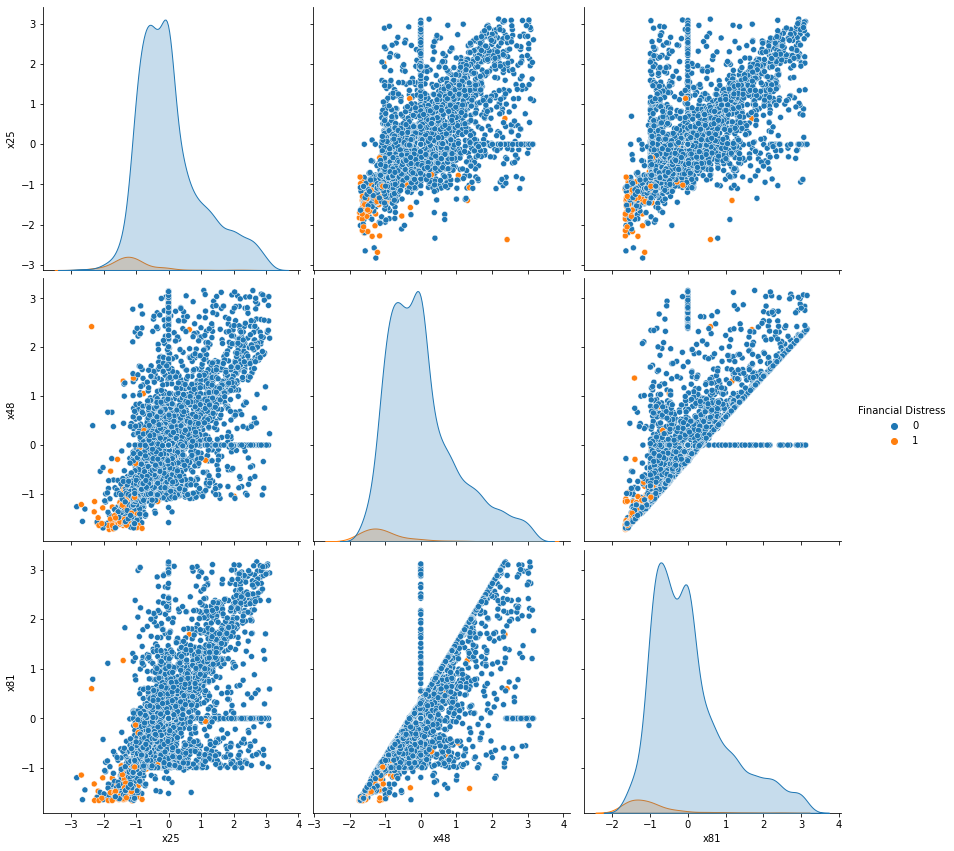

In [39]:
sns.pairplot(df_scatter ,hue= 'Financial Distress', height= 4);

In [40]:
x = df_scatter.iloc[:,0:3]
y = df_scatter['Financial Distress']


In [41]:
df_scatter.shape

(3672, 4)

use processed_data

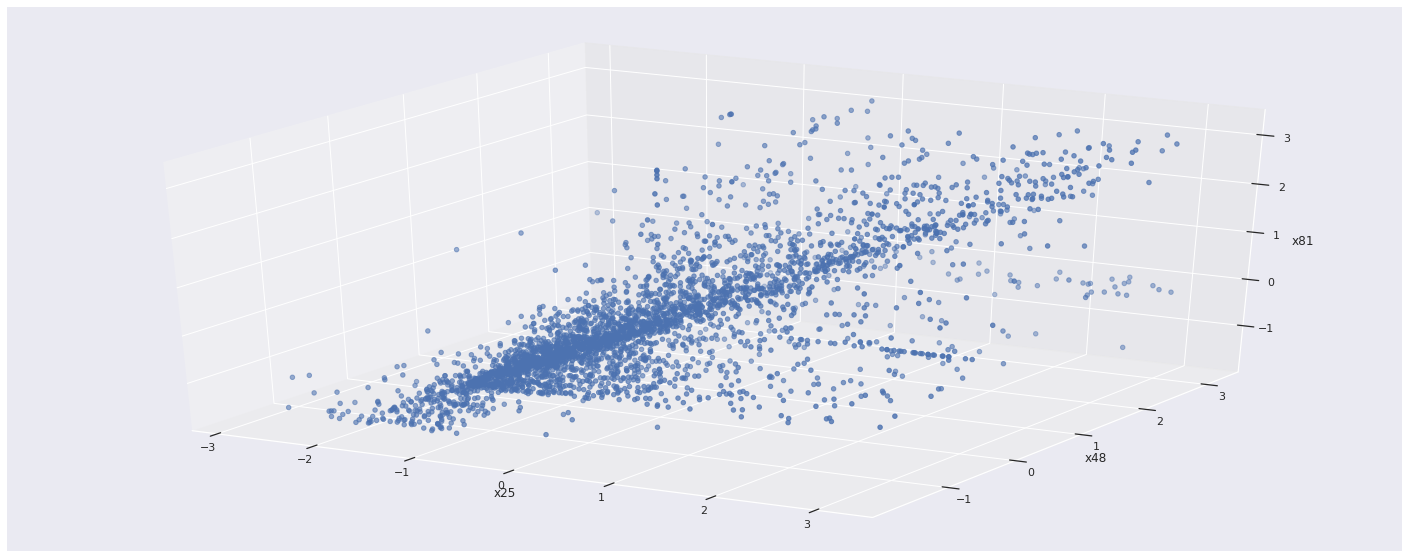

In [47]:
from mpl_toolkits.mplot3d import Axes3D

#df = pd.read_csv('2016.csv')
sns.set(style = "darkgrid")
sns.color_palette("bright")

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection = '3d')
##sty='darkgrid'
#ax.set_title('style: {!r}'.format(sty), color='C2')

#x = df_areaPlot['Financial Distress']
x = df['x25']
y = df['x48']
z = df['x81']
target = df_scatter[['Financial Distress']]
#target[(target<=-0.5)] = 1; 
#target[(target>-0.5)] =0;
c = target

ax.set_xlabel("x25")
ax.set_ylabel("x48")
ax.set_zlabel("x81")

#ax.scatter(x,c='b', y, z,c='r')
ax.scatter(x, y, z, cmap=c,marker='o') #use hue 


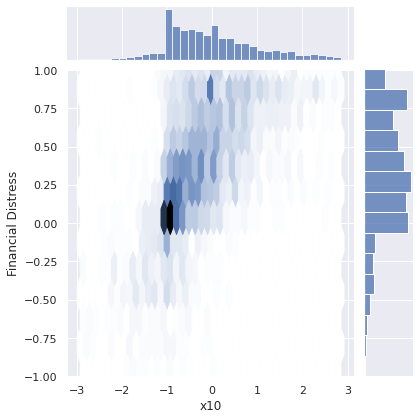

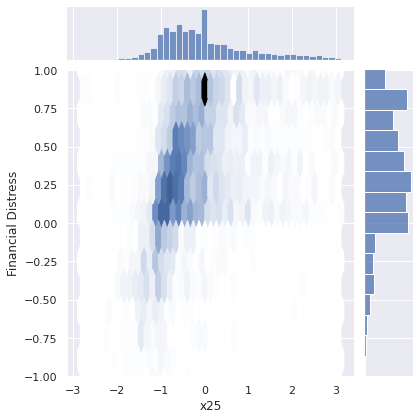

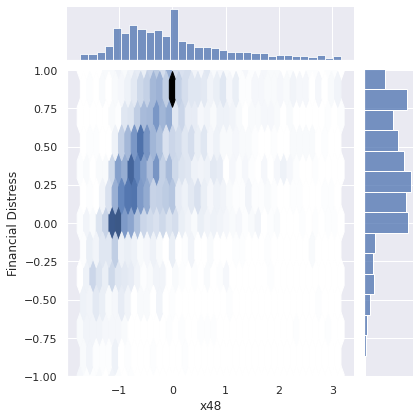

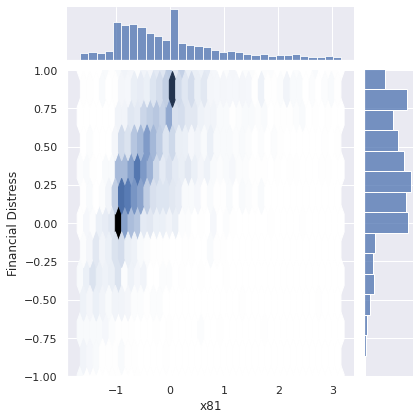

In [48]:
sns.jointplot(x = df['x10'], y = df['Financial Distress'], kind = 'hex', ylim=(-1,1))
sns.jointplot(x = df['x25'], y = df['Financial Distress'], kind = 'hex', ylim=(-1,1))
sns.jointplot(x = df['x48'], y = df['Financial Distress'], kind = 'hex', ylim=(-1,1))
sns.jointplot(x = df['x81'], y = df['Financial Distress'], kind = 'hex', ylim=(-1,1))

# Model Building

Models we are considering to try:

1) Linear (Ridge,Lasso, Elastic Net , other types) - Navneeth

2) Polynomial (Ridge, Lasso, Elastic Net, other types) - Bentic

3) SGD,SVM,KNN,Neural Net - Sharath

4) Decision Trees, Ensemble Methods - Sumanth

In [14]:
#get resreg
!pip install resreg

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
import resreg
from sklearn.ensemble import StackingRegressor

## Functions used for Dashboard

Raw Data

In [16]:
def load_data():
  df = pd.read_csv('Financial Distress.csv')
  return df

Pre Processed Data

In [17]:
def processed_df(df):
    '''
    Function for getting cleaned and transformed data)
    '''
    #df = pd.read_csv('Financial Distress.csv')
    df1 = df.iloc[:, 3:]
    df1 = df1.drop('x80', axis =1)
    
    Q1=df1.quantile(q=0.25)                      
    Q3=df1.quantile(q=0.75)
    IQR= Q3-Q1
    
    fd = df[['Financial Distress']] #
    Q1fd=fd.quantile(q=0.25)                      
    Q3fd=fd.quantile(q=0.75)
    IQRfd= Q3fd-Q1fd

    df_fd = fd[(fd >=(Q1fd-3*IQRfd))& (fd <= Q3fd+3*IQRfd)]  


    df_inp = df1[(df1 >=(Q1-1.5*IQR))& (df1 <= Q3+1.5*IQR)]
    df_inp = pd.concat([df_fd, df_inp], axis =1)

    imp_mean= SimpleImputer(missing_values=np.nan,strategy='mean')
    imp_mean.fit(df_inp)
    df_imp = pd.DataFrame(imp_mean.transform(df_inp))
    col = df1.columns.insert(0, 'Financial Distress')
    df_imp.columns = col
    
    scaler=StandardScaler()
    df_scal = copy.deepcopy(df_imp)
    df_scal = df_scal.iloc[:, 1:]
    
    model = scaler.fit(df_scal)
    scaled_data= pd.DataFrame(model.transform(df_scal))   
    scaled_data.columns= df_scal.columns

    df_findis = df_imp[['Financial Distress']]
    df_final =  pd.concat([df_findis, scaled_data], axis =1)
    #   scaled_data = scaled_data.iloc[:, :]
    #scaled_data = pd.concat([scaled_fd, scaled_data], axis =1)
    
    return df_final

Descriptive Statistics

In [5]:
def descriptive_stats(df_):  
  '''Function for descriptive statisctics'''        
  ds = df_.describe()
  temp  = pd.concat([df_.skew(), df_.kurtosis()], axis = 1)
  temp.columns = ['skewness', 'kurtosis']
  temp = temp.T
  stats = pd.concat([ds, temp])
  return stats

Correlation 

In [6]:
def get_corr(df ,pos, neg):
  
  '''Function that returns correlation dictionary for each feature which can be useful for analysing dependency among features and target variable'''
  corr_df = df.corr()
  corr_df = pd.DataFrame(corr_df)
  fd_corr = corr_df.iloc[0, :] 

  corr = pd.DataFrame(corr_df[(corr_df>=pos)|(corr_df<= neg)])
  corr_dict = {}
  for f in corr.index:
    corr_dict[f] = pd.DataFrame(corr.sort_values(f)[f].dropna())
  return corr_df, fd_corr, corr_dict
  

Train Validation Test split

In [7]:
def get_train_val_test_data(df,val = False,poly= False, crit = -0.5, rel_thresh = 0.8, ovr = 3.0, rare_percentile = 4):
  '''Function that splits data into Train, Test and Validation set with oversampling rare domain'''
  T = df.iloc[:, 0]
  X = df.iloc[:, 1:]
 
  #polynomial
  if poly: 
    poly_reg = PolynomialFeatures(degree=3)
    X = poly_reg.fit_transform(X)
  #dimensionality reduction and feature selection
  #reduce_dimensions(df, 10, 20,X_train, True)  #feature_selection_RFECV(model,1,5,X_train,t_train)
  #feature_selection_VT(X_train,0.8)
 
  y = copy.deepcopy(T)
  y[(y>=crit)] = 0; y[(y<crit)] = 1
  X_train, X_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=15, stratify = y)

  #polynomial
  #X_poly = poly_reg.fit_transform(X_train)

  relevance = resreg.sigmoid_relevance(t_train, cl=np.percentile(T, rare_percentile), ch=None)
  X_train, t_train = resreg.random_oversample(X_train, t_train, relevance, relevance_threshold=rel_thresh, over= ovr, random_state=34)
  if val:         #to return validation set val = True when calling the function
    y1 = copy.deepcopy(t_train)
    y1[(y1>=crit)] = 0; y1[(y1<crit)] = 1
    X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.15, random_state = 15, stratify = y1)
    return  X_train, X_val, X_test, t_train, t_val, t_test
  else:
    return X_train, X_test, t_train, t_test

In [19]:
def get_train_val_test_data_poly(df,val = False, crit = -0.5, rel_thresh = 0.8, ovr = 3.0, rare_percentile = 4):
  '''Function that splits data into Train, Test and Validation set with oversampling rare domain'''
  T = df.iloc[:, 0]
  X = df.iloc[:, 1:]
 
  #polynomial 
  poly_reg = PolynomialFeatures(degree=3)
  #polynomial
  X_poly = poly_reg.fit_transform(X)
  #dimensionality reduction and feature selection
  #reduce_dimensions(df, 10, 20,X_train, True)  #feature_selection_RFECV(model,1,5,X_train,t_train)
  #feature_selection_VT(X_train,0.8)
 
  y = copy.deepcopy(T)
  y[(y>=crit)] = 0; y[(y<crit)] = 1
  X_train, X_test, t_train, t_test = train_test_split(X_poly, T, test_size=0.2, random_state=15, stratify = y)



  relevance = resreg.sigmoid_relevance(t_train, cl=np.percentile(T, rare_percentile), ch=None)
  X_train, t_train = resreg.random_oversample(X_train, t_train, relevance, relevance_threshold=rel_thresh, over= ovr, random_state=34)
  if val:         #to return validation set val = True when calling the function
    y1 = copy.deepcopy(t_train)
    y1[(y1>=crit)] = 0; y1[(y1<crit)] = 1
    X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.15, random_state = 15, stratify = y1)
    return  X_train, X_val, X_test, t_train, t_val, t_test
  else:
    return X_train, X_test, t_train, t_test

Train Model


In [20]:
def train_model( model, X_train, t_train ):
  '''Function that return the trained model'''
  model.fit(X_train, t_train)
  return model 

Evaluate Validation and Test Data

In [32]:
def evaluation_report(train_model, X_train, t_train, X_test, t_test, val = False, crit = -0.5):
  '''Function that results evaluation report'''
  pred_val = train_model.predict(X_test)
  true_val = t_test
  y = copy.deepcopy(t_train)
  y[(y>=crit)] = 0; y[(y<crit)] = 1
  ytr = copy.deepcopy(t_train)
  ytr[(ytr>=crit)] = 0; ytr[(ytr<crit)] = 1
  ytst = copy.deepcopy(t_test)
  ytst[(ytst>=crit)] = 0; ytst[(ytst<crit)] = 1

  plt.figure(figsize=(12,4))
  plt.subplot(131)
  axi = sns.distplot(true_val, hist = False, color = 'g', label = "Actual Value", bins = 20)
  sns.distplot(pred_val, hist = False, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
  plt.legend(loc="upper right")

  plt.subplot(132)
  sns.scatterplot(true_val, pred_val)
  plt.plot([crit]*8, range(-4, 4, 1), 'r')
  plt.plot(range(-5, 20, 1), [crit]*25, 'r')
  plt.xlabel('True Value')
  plt.ylabel('Predicted Value')

  true_class = copy.deepcopy(true_val); true_class[(true_class>=crit)] = 0; true_class[(true_class<crit)] = 1
  pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=crit)] = 0; pred_class[(pred_class<crit)] = 1
  cm = confusion_matrix(true_class, pred_class)
  cm_display = ConfusionMatrixDisplay(cm,display_labels=['1','0']).plot()
  #cm_display = ConfusionMatrixDisplay(cm,display_labels=['True','Predicted']).plot()

  results = {}
  # results['True Values set range'] = true_val.min()) (true_val.max())
  # results['Predicted Values set range'] = str(pred_val.min())+','+ str(pred_val.max())
  results['True values min'] = (true_val.min())
  results['True values max'] = (true_val.max())

  results['Predicted Values min'] = (pred_val.min())
  results['Predicted Values max'] = (pred_val.max())
  results['Accuracy'] = str(accuracy_score(true_class, pred_class)*100) + '%'
  results['R2 score'] = r2_score(true_val, pred_val)
  results['Mean Squared error'] = mean_squared_error(true_val, pred_val)
  results['Max Error'] = max_error(true_val, pred_val)
  results['Total Train Samples'] = X_train.shape[0]
  results['Total ratio of 0s and 1s in Train'] = np.count_nonzero(ytr == 0)/np.count_nonzero(ytr == 1)
  if val:
    results['Total validation Samples'] = X_test.shape[0]
    results['Total ratio of 0s and 1s in Validation'] = np.count_nonzero(ytst == 0)/np.count_nonzero(ytst == 1)
  else:
    results['Total Test Samples'] = X_test.shape[0]
    results['Total ratio of 0s and 1s in Test'] = np.count_nonzero(ytst == 0)/np.count_nonzero(ytst == 1)
  results = pd.DataFrame(results, index = [0])
  display(results)
  

  

  


All Models

In [59]:

model_knn = KNeighborsRegressor(n_neighbors=100, weights= 'uniform', algorithm='brute',leaf_size = 10, metric='canberra', p =2)

model_svr_sig = SVR(kernel='sigmoid', degree=3, gamma='scale', epsilon=0.001, C=7, coef0= -1.4)
#third best mdodel
model_nn = MLPRegressor(hidden_layer_sizes=(45,), activation= 'identity', solver = 'adam', alpha= 0.00001, learning_rate= 'adaptive', 
                     learning_rate_init=0.00005, max_iter= 100000, warm_start=True, early_stopping= True)
#************
model_svr_rbf = SVR(kernel='rbf', degree=2, gamma='auto', epsilon=0.001, C=100)
#best so far 
model_linear_elastic = ElasticNet(alpha=0.05,l1_ratio= 0.5, max_iter=1000, tol=0.00001, fit_intercept= True, warm_start=False)    
#************
model_svr_poly = SVR(kernel='poly', degree=5, gamma='auto', epsilon=0.01, C=100, coef0= 1)
model_svr_linear = SVR(kernel = 'linear', epsilon = 0.001, C =10)
model_sgd = SGDRegressor(loss='epsilon_insensitive',power_t=0.05, penalty='elasticnet', l1_ratio=0.5, alpha= 0.01, epsilon= 0.001, learning_rate='optimal', max_iter= 100000, eta0=0.00001)
#model_linear_svr = LinearSVR(epsilon = 0.0001, C = 100, fit_intercept= True)
model_linear_Lasso = Lasso(alpha=0.000001,tol=0.0001,selection='random',max_iter= 10000000, copy_X=True,fit_intercept=True)
model_linear = LinearRegression(fit_intercept=True,normalize=True,n_jobs=1,copy_X=True)
#second best model 
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, min_samples_leaf=3, max_features=10)
#************
model_linear_ridge = Ridge(alpha=0.000001,tol=0.00001,solver='sparse_cg',copy_X=True,fit_intercept=True)

model_dt = DecisionTreeRegressor(max_depth=9, splitter= 'best' , max_leaf_nodes=15 , criterion= 'mse') 
model_etr = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=45,min_samples_leaf=45)

model = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)                                  # best parameters we will do grid search in the Future to see evaluate overall
#evaluation_report_polynomial_test(model, 34, 67)
#evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)

For getting data

In [34]:
df = load_data()
df_processed = processed_df(df)
X_train, X_val, X_test, t_train, t_val, t_test = get_train_val_test_data(df_processed, val = True)


Run models

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

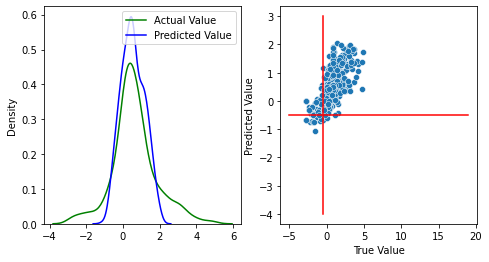

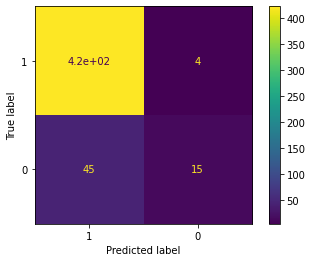

In [35]:
model_knn = KNeighborsRegressor(n_neighbors=100, weights= 'uniform', algorithm='brute',leaf_size = 10, metric='canberra', p =2)
trained_model = train_model(model_knn, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

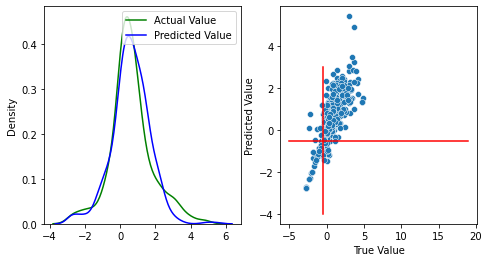

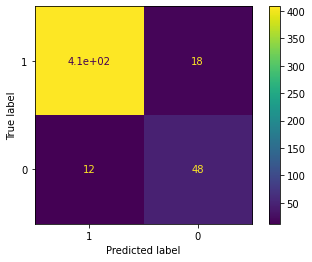

In [36]:
model_svr_sig = SVR(kernel='sigmoid', degree=3, gamma='scale', epsilon=0.001, C=7, coef0= -1.4)
trained_model = train_model(model_svr_sig, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

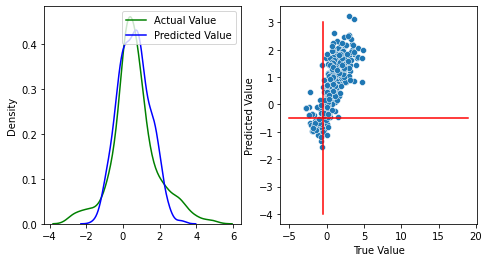

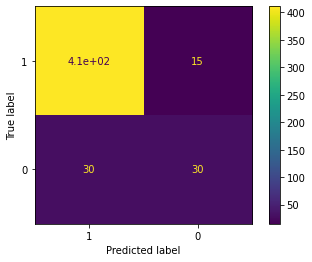

In [37]:
model_nn = MLPRegressor(hidden_layer_sizes=(45,), activation= 'identity', solver = 'adam', alpha= 0.00001, learning_rate= 'adaptive', 
                     learning_rate_init=0.00005, max_iter= 100000, warm_start=True, early_stopping= True)
trained_model = train_model(model_nn, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

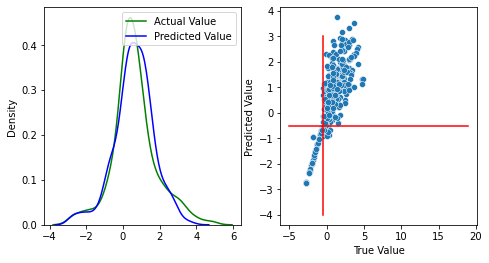

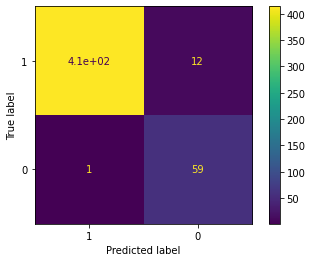

In [38]:
model_svr_rbf = SVR(kernel='rbf', degree=2, gamma='auto', epsilon=0.001, C=100)
trained_model = train_model(model_svr_rbf, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

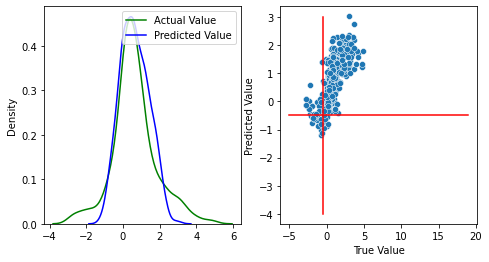

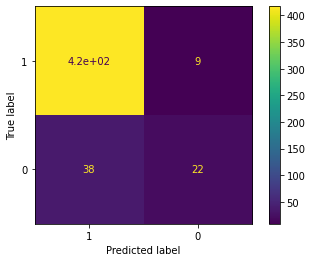

In [39]:
model_linear_elastic = ElasticNet(alpha=0.05,l1_ratio= 0.5, max_iter=1000, tol=0.00001, fit_intercept= True, warm_start=False)    
trained_model = train_model(model_linear_elastic, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

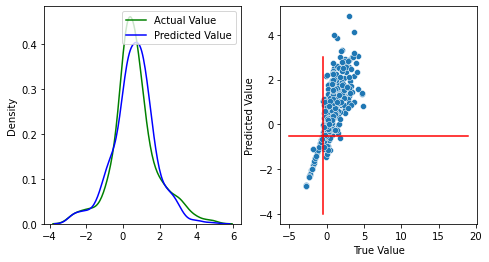

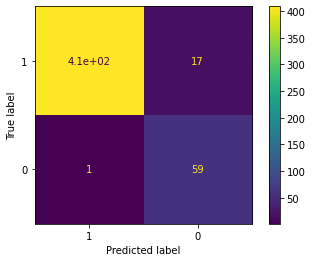

In [40]:
model_svr_poly = SVR(kernel='poly', degree=5, gamma='auto', epsilon=0.01, C=100, coef0= 1)    
trained_model = train_model(model_svr_poly, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

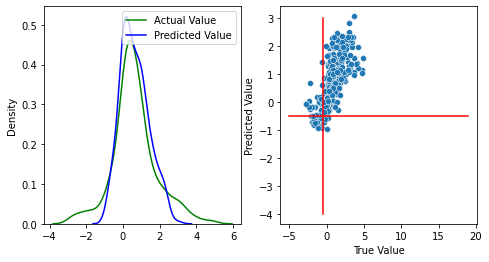

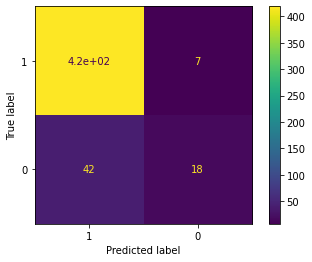

In [41]:
model_svr_linear = SVR(kernel = 'linear', epsilon = 0.001, C =10)  
trained_model = train_model(model_svr_linear, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

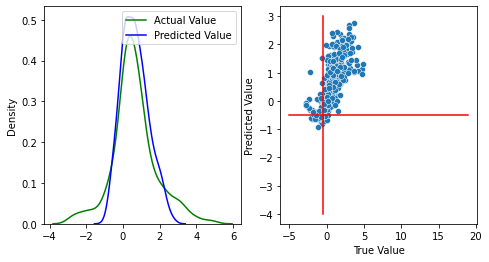

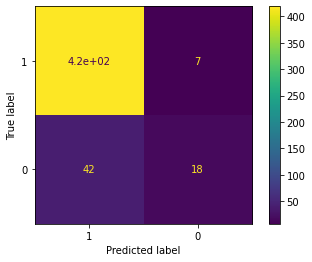

In [48]:
model_sgd = SGDRegressor(loss='epsilon_insensitive',power_t=0.05, penalty='elasticnet', l1_ratio=0.5, alpha= 0.01, epsilon= 0.001, learning_rate='optimal', max_iter= 100000, eta0=0.00001)   
trained_model = train_model(model_sgd, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

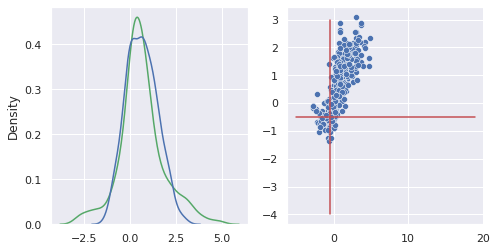

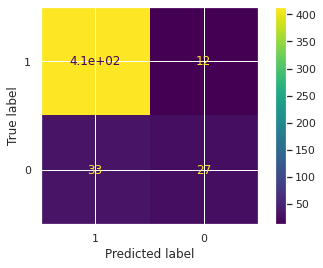

In [70]:
model_linear_Lasso = Lasso(alpha=0.000001,tol=0.0001,selection='random',max_iter= 10000000, copy_X=True,fit_intercept=True)   
trained_model = train_model(model_linear_Lasso, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

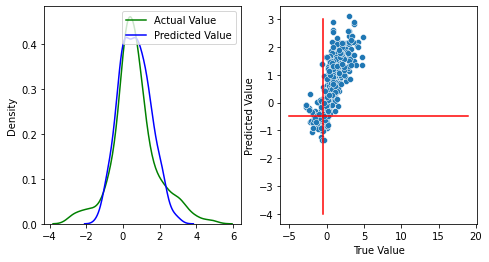

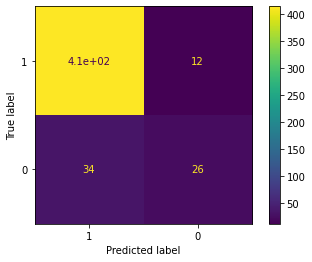

In [42]:
model_linear = LinearRegression(fit_intercept=True,normalize=True,n_jobs=1,copy_X=True)
trained_model = train_model(model_linear, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

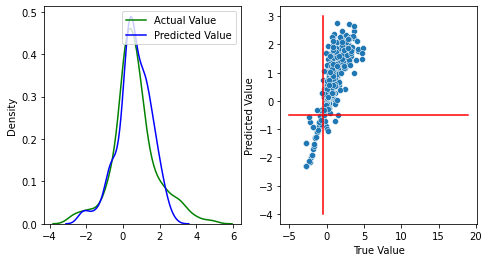

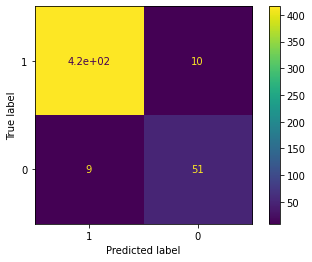

In [43]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, min_samples_leaf=3, max_features=10)  
trained_model = train_model(model_rf, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

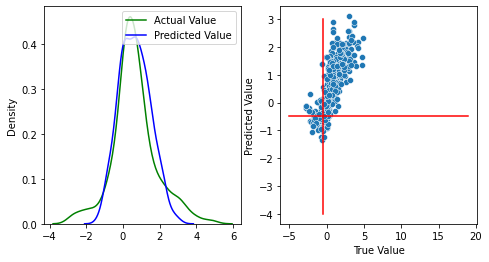

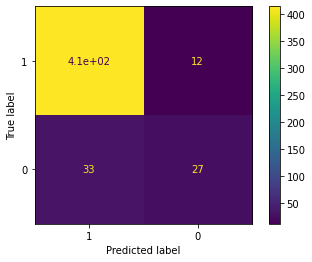

In [44]:
model_linear_ridge = Ridge(alpha=0.000001,tol=0.00001,solver='sparse_cg',copy_X=True,fit_intercept=True)
trained_model = train_model(model_linear_ridge, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

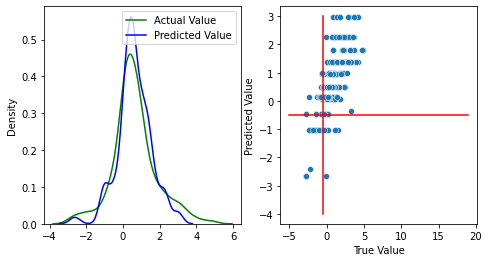

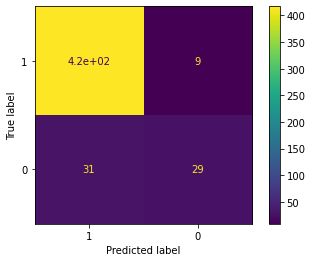

In [45]:
model_dt = DecisionTreeRegressor(max_depth=9, splitter= 'best' , max_leaf_nodes=15 , criterion= 'mse')   
trained_model = train_model(model_dt, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

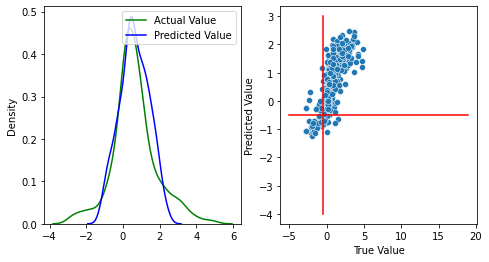

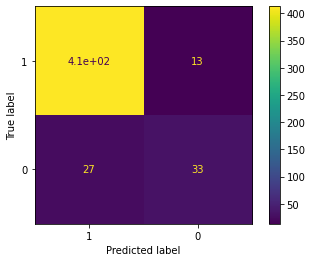

In [46]:
model_etr = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=45,min_samples_leaf=45)  
trained_model = train_model(model_etr, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Validation
0          -2.7519  ...                                     7.1

[1 rows x 12 columns]

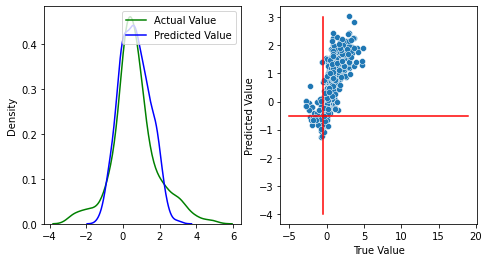

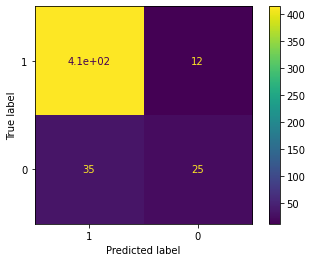

In [47]:
model = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)  
trained_model = train_model(model, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

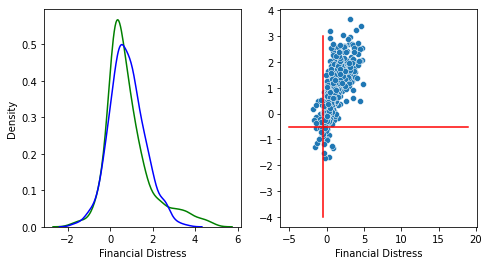

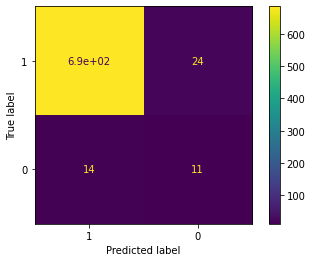

In [ ]:
# Polynomial degree=2
model_poly_ElasticNet = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)
trained_model = train_model(model_poly_ElasticNet, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_val, t_val, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

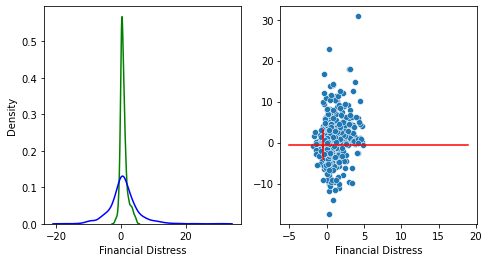

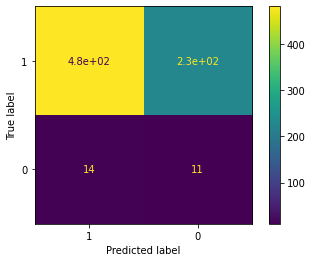

In [ ]:
#Polynomial degree=2
model_poly_Ridge = Ridge(alpha=0.008,max_iter=1000,tol=0.001)  
trained_model = train_model(model_poly_Ridge, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.47144050973219, tolerance: 0.382263437646169
  positive)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/pyt

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

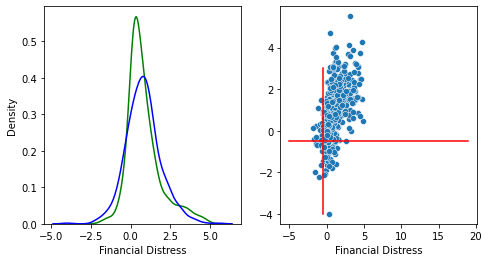

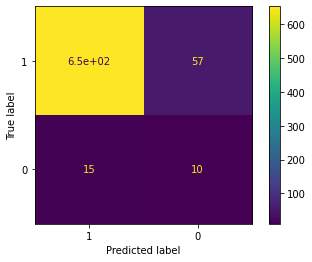

In [ ]:
#Polynomial degree=2
model_poly_Lasso = Lasso(alpha=0.001,max_iter=1000, tol=0.0001, warm_start=False) 
trained_model = train_model(model_poly_Lasso, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

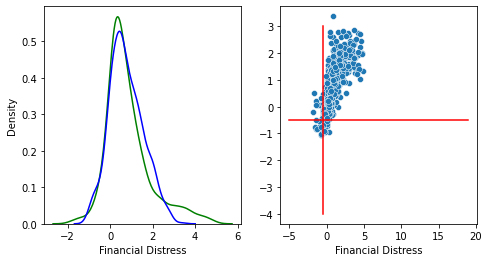

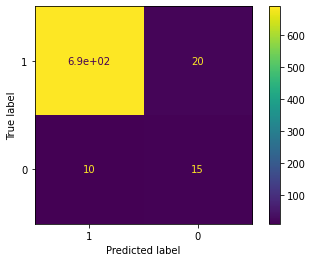

In [ ]:
#Polynomial degree=3
model_poly_ElasticNet = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)
trained_model = train_model(model_poly_ElasticNet, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

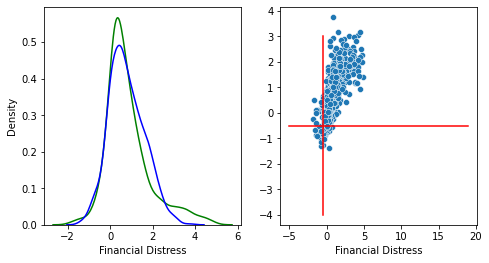

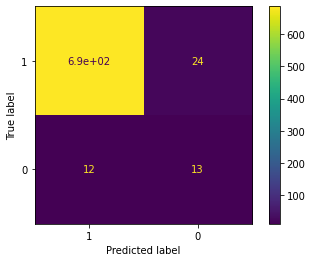

In [ ]:
#Polynomial degree=3
model_poly_Ridge = Ridge(alpha=0.008,max_iter=1000,tol=0.001)  
trained_model = train_model(model_poly_Ridge, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Values set range  ...  Total ratio of 0s and 1s in Validation
0                -1.8385  ...                                    28.4
1                 4.8878  ...                                    28.4

[2 rows x 10 columns]

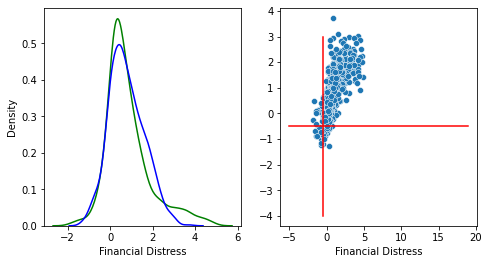

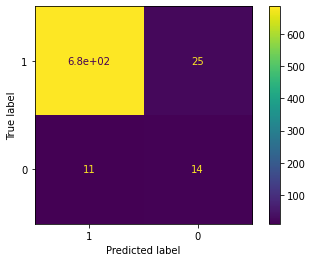

In [ ]:
#Polynomial degree=3
model_poly_Lasso = Lasso(alpha=0.001,max_iter=1000, tol=0.0001, warm_start=False) 
trained_model = train_model(model_poly_Lasso, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = True)

For Testing Stacked Model

In [25]:
df = load_data()
df_processed = processed_df(df)
X_train, X_test, t_train, t_test = get_train_val_test_data(df_processed, val = False)

In [26]:
estimators = [
    ('Elastic', model_linear_elastic),
    ('Random', model_rf),
    ('MLP', model_nn)
]

stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator= ElasticNet(alpha=0.05,l1_ratio= 0.5, max_iter=1000, tol=0.00001, fit_intercept= True, warm_start=False)
)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True values min  ...  Total ratio of 0s and 1s in Test
0          -1.8385  ...                              28.4

[1 rows x 12 columns]

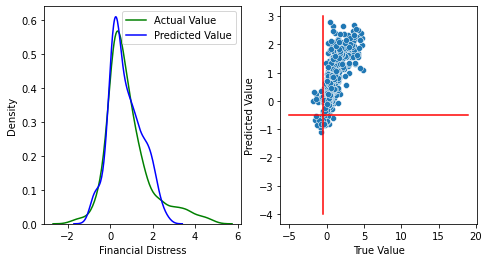

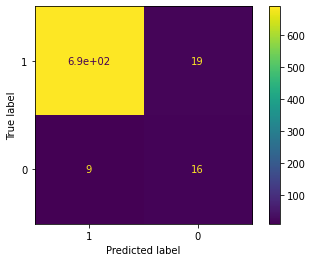

In [33]:
#stacked_model = #
trained_model = train_model(stacked_model, X_train, t_train )
evaluation_report(trained_model, X_train, t_train, X_test, t_test, val = False)

## Previous Functions(To Be deleted)

In [ ]:
# Fea_Selector = [PCA, RFECV, VarianceThreshold]
# model_b = [Polynomial, Ridge, Lasso, Elastic Net ]
# model_n = [Linear, Ridge, Lasso, Elastic Net]
# model_sh = [SGD, SVM, KNN]
# model_su = [Decision Tree, Random Forest, Extra Trees, Ada Boost, XG Boost, Gradient Boost]

Blueprint for Model Training and Validating 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Validation set range: -2.5355944635954732, 7.215954151817963
Predicted Validation set range: -0.7029292083324846, 0.8041138178634722
Correclty Classified: 92.29024943310658%
R2 score: 0.29140223952672994
Mean Squared error on Original Data set: 0.2981304714395242


NameError: ignored

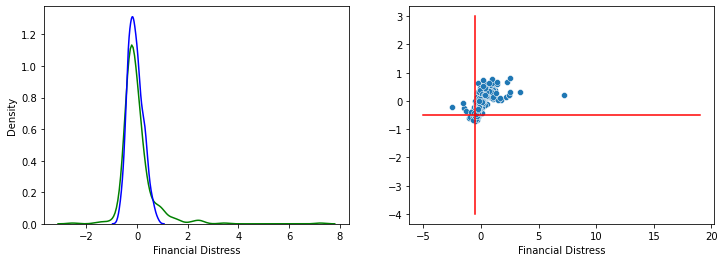

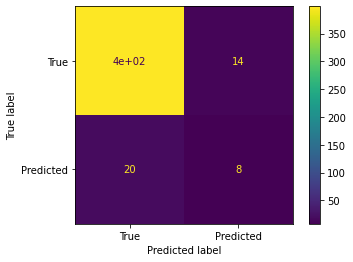

In [ ]:
model = SVR(kernel='linear', C=1) 
def evaluation_report(model, r1, r2): 
    T = df.iloc[:, 0]
    X = df.iloc[:, 1:]
#     X= SelectKBest(f_regression, k = 60).fit_transform(X, T)
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)
    X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)
    model.fit(X_train, t_train)
    y_predict = model.predict(X_val)
    true_val, pred_val = t_val, y_predict
    #od = pd.read_csv('Financial Distress.csv')
    #od['Financial Distress']  
    #true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    #pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = False, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = False, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm,display_labels=['True','Predicted']).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_val, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    print('Mean Absolute Error: {}'.format(mean_absolute_error(true_val, pred_val)))
    print('Mean Absolute Percent Error: {}'.format(mean_absolute_percentage_error(true_val, pred_val)))
    print('Max Error: {}'.format(max_error(true_val, pred_val)))

evaluation_report(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating

Blueprint for Dimension Reduction


In [ ]:
# Fea_Selector = [PCA, RFECV, VarianceThreshold]
#PCA dimensionality reduction
#60 to 81 has good improvements to  R2 score 
from sklearn.decomposition import PCA

def reduce_dimensions(model, r1, r2, X_train,hist_): 
  pca = PCA(n_components=20)
  principalComponents = pca.fit_transform(X_train)
  principalDf = pd.DataFrame(data = principalComponents)

#reduce_dimensions(df, 10, 20,X_train, True)

Feature Selection

In [ ]:
#Feature Selection
from sklearn.feature_selection import RFECV
#60 to 81 has good improvements to  R2 score 

def feature_selection_RFECV(model,step_,cv_,X_train,t_train):

  selector = RFECV(model, step=step_, cv=cv_)
  selector = selector.fit(X_train, t_train)
  selector.support_
  #array([ True,  True,  True,  True,  True, False, False, False, False,
  #       False])
  selector.ranking_
  #array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

#feature_selection_RFECV(model,1,5,X_train,t_train)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
#60 to 81 has good improvements to  R2 score 

def feature_selection_VT(X_train,threshold):
  sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
  sel.fit_transform(X_train)

#feature_selection_VT(X_train,0.8)

# Best Models After Tests

Polynomial ElasticNet Regression (degree=3)

In [ ]:
#test cell #Polynomial Regression
def evaluation_report_LinearRegression_Poly_test(model,poly_reg, r1, r2):         #pass the model object that you created & r1, r2 are random state
                                              # that splits the training in to testing and validating
    '''Function that evaluates Trained Model on Validation set'''
    T = df.iloc[:, 0]
    T[(T>=48)]=T.mean()#remove outliers
    X = df.iloc[:, 1:]
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)
   # X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)
 
    #create polynomial features
    #poly_reg = PolynomialFeatures(degree=4)
    X_poly = poly_reg.fit_transform(X_train)
    #model = LinearRegression()
 
    #feature selection and dimension reduction
    reduce_dimensions(df, 10, 20,X_train, True)
    feature_selection_RFECV(model,1,5,X_train,t_train)
    feature_selection_VT(X_train,0.8)
 
    #model.fit(X_poly, t_train)
 
    #
    model.fit(X_poly, t_train)
    X_val_poly=poly_reg.fit_transform(X_test)
    y_predict = model.predict(X_val_poly)
    true_val, pred_val = t_test, y_predict
    # od = pd.read_csv('Financial Distress.csv')
    # od['Financial Distress']  
    # true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    # pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = True, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = True, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm,display_labels=['True','Predicted']).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_test, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    
#evaluation_report(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating

In [ ]:
poly_reg = PolynomialFeatures(degree=3)
 model = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)                                  # best parameters we will do grid search in the Future to see evaluate overall
 #reduce_dimensions(df, 10, 20,X_train, True)
#feature_selection_RFECV(model_b,1,5,X_train,t_train)
#feature_selection_VT(X_train,0.8)
#evaluation_report_polynomial(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating
 
#evaluation_report_polynomial_test(model, 34, 67)
evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)

IndentationError: ignored

Linear - Lasso Regression

In [ ]:
model = Lasso(alpha=0.01,tol=0.001,selection='random',copy_X=True,fit_intercept=False)

evaluation_report(model, 34, 67)

In [ ]:
#Polynomial Regression
def evaluation_report_LinearRegression_Poly(model,poly_reg, r1, r2):         #pass the model object that you created & r1, r2 are random state
                                              # that splits the training in to testing and validating
    '''Function that evaluates Trained Model on Validation set'''
    T = df.iloc[:, 0]
    T[(T>=48)]=T.mean()#remove outliers
    X = df.iloc[:, 1:]
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)
    X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)

    #create polynomial features
    #poly_reg = PolynomialFeatures(degree=4)
    X_poly = poly_reg.fit_transform(X_train)
    #model = LinearRegression()

    #feature selection and dimension reduction
    reduce_dimensions(df, 10, 20,X_train, True)
    feature_selection_RFECV(model,1,5,X_train,t_train)
    feature_selection_VT(X_train,0.8)

    #model.fit(X_poly, t_train)

    #
    model.fit(X_poly, t_train)
    X_val_poly=poly_reg.fit_transform(X_val)
    y_predict = model.predict(X_val_poly)
    true_val, pred_val = t_val, y_predict
    # od = pd.read_csv('Financial Distress.csv')
    # od['Financial Distress']  
    # true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    # pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = True, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = True, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm,display_labels=['True','Predicted']).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_val, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    
#evaluation_report(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating

In [ ]:
#test cell #Polynomial Regression
def evaluation_report_LinearRegression_Poly_test(model,poly_reg, r1, r2):         #pass the model object that you created & r1, r2 are random state
                                              # that splits the training in to testing and validating
    '''Function that evaluates Trained Model on Validation set'''
    T = df.iloc[:, 0]
    T[(T>=48)]=T.mean()#remove outliers
    X = df.iloc[:, 1:]
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)
   # X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)
 
    #create polynomial features
    #poly_reg = PolynomialFeatures(degree=4)
    X_poly = poly_reg.fit_transform(X_train)
    #model = LinearRegression()
 
    #feature selection and dimension reduction
    reduce_dimensions(df, 10, 20,X_train, True)
    feature_selection_RFECV(model,1,5,X_train,t_train)
    feature_selection_VT(X_train,0.8)
 
    #model.fit(X_poly, t_train)
 
    #
    model.fit(X_poly, t_train)
    X_val_poly=poly_reg.fit_transform(X_test)
    y_predict = model.predict(X_val_poly)
    true_val, pred_val = t_test, y_predict
    # od = pd.read_csv('Financial Distress.csv')
    # od['Financial Distress']  
    # true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    # pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = True, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = True, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm,display_labels=['True','Predicted']).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_test, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    
#evaluation_report(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating

Polynomial Ridge Regression Model


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1184268847498942, tolerance: 0.10911168758738037
  positive)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-pac

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.7302659728514884, 3.0725585626422944
Correclty Classified: 85.03401360544217%
R2 score: 0.21024657817428216
Mean Squared error on Original Data set: 0.29394144178790865


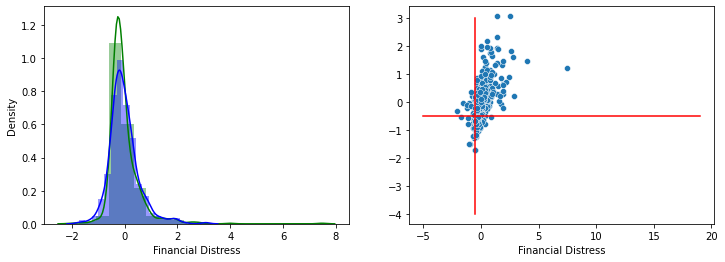

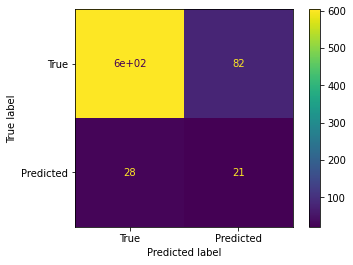

In [ ]:
#Ridge Regression
poly_reg = PolynomialFeatures(degree=3)
model_b = Ridge(alpha=0.008,max_iter=1000,tol=0.001)                                  # best parameters we will do grid search in the Future to see evaluate overal
#reduce_dimensions(df, 10, 20,X_train, True)
#feature_selection_RFECV(model_b,1,5,X_train,t_train)
#feature_selection_VT(X_train,0.8)

#evaluation_report_polynomial(model_b, 34, 67)
#evaluation_report_polynomial_test(model_b, 34, 67)

evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)


Polynomial Lasso Regression Model



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1184268847498942, tolerance: 0.10911168758738037
  positive)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-pac

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.7302659728514884, 3.0725585626422944
Correclty Classified: 85.03401360544217%
R2 score: 0.21024657817428216
Mean Squared error on Original Data set: 0.29394144178790865


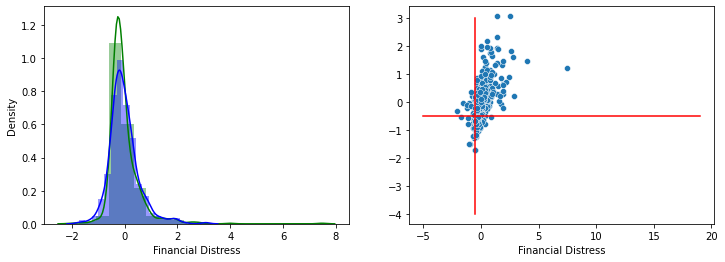

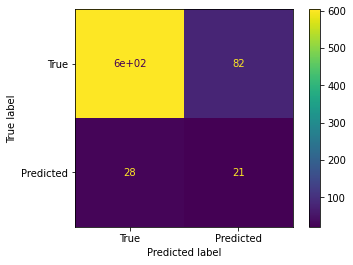

In [ ]:
#Lasso
poly_reg = PolynomialFeatures(degree=3)
model = Lasso(alpha=0.001,max_iter=1000, tol=0.0001, warm_start=False)   # pass the parameters and arguments of your model here and play with them to determine 
#reduce_dimensions(df, 10, 20,X_train, True)
##feature_selection_RFECV(model_b,1,5,X_train,t_train)
#feature_selection_VT(X_train,0.8)

#evaluation_report_polynomial(model, 34,67)
#evaluation_report_polynomial_test(model, 34, 67)
evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)

Polynomial ElasticNet Regression Model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1341978120271392, tolerance: 0.10911168758738037
  positive)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-pac

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.0446507021333125, 2.7984716227872224
Correclty Classified: 93.87755102040816%
R2 score: 0.46034742653733784
Mean Squared error on Original Data set: 0.2008554203430545


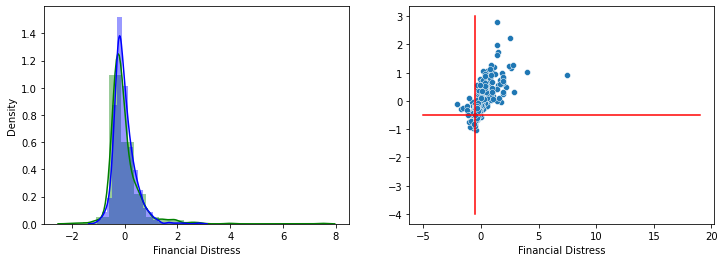

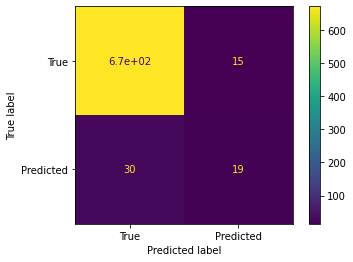

In [ ]:
 poly_reg = PolynomialFeatures(degree=3)
 model = ElasticNet(alpha=0.02,max_iter=1000, tol=0.0001, warm_start=False)                                  # best parameters we will do grid search in the Future to see evaluate overall
 #reduce_dimensions(df, 10, 20,X_train, True)
#feature_selection_RFECV(model_b,1,5,X_train,t_train)
#feature_selection_VT(X_train,0.8)
#evaluation_report_polynomial(model, 34, 67) # call the function you're welcome to add you own plots and metrics in evaluating

#evaluation_report_polynomial_test(model, 34, 67)
evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)

Polynomial Regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -2.1807816198458374, 3.8194949039160795
Correclty Classified: 79.8639455782313%
R2 score: -0.32239027473583204
Mean Squared error on Original Data set: 0.4921856534202372


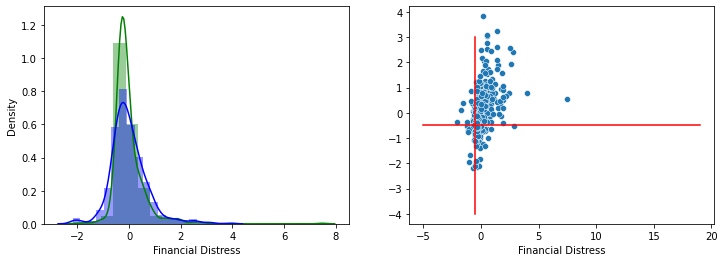

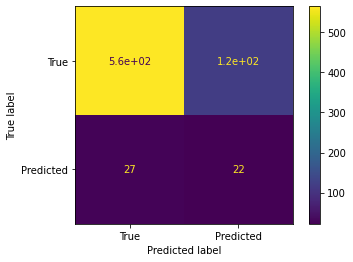

In [ ]:
#Polynomial degree 3
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
model=LinearRegression()
#evaluation_report_LinearRegression_Poly(poly_reg, 34, 67)
evaluation_report_LinearRegression_Poly_test(model,poly_reg, 34, 67)
 
#X_poly = poly_reg.fit_transform(X_train)
#pol_reg = LinearRegression()
#pol_reg.fit(X_poly, y)

Modules

In [ ]:
!pip install resreg

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 
#import resreg
import copy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,mean_absolute_error,max_error

Dimensionality Reduction

In [ ]:
# Fea_Selector = [PCA, RFECV, VarianceThreshold]
#PCA dimensionality reduction
#60 to 81 has good improvements to  R2 score 
from sklearn.decomposition import PCA

def reduce_dimensions(model, r1, r2, X_train,hist_): 
  pca = PCA(n_components=20)
  principalComponents = pca.fit_transform(X_train)
  principalDf = pd.DataFrame(data = principalComponents)

#reduce_dimensions(df, 10, 20,X_train, True)

Feature Selection

In [ ]:
#Feature Selection
from sklearn.feature_selection import RFECV
#60 to 81 has good improvements to  R2 score 

def feature_selection_RFECV(model,step_,cv_,X_train,t_train):

  selector = RFECV(model, step=step_, cv=cv_)
  selector = selector.fit(X_train, t_train)
  selector.support_
  #array([ True,  True,  True,  True,  True, False, False, False, False,
  #       False])
  selector.ranking_
  #array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

#feature_selection_RFECV(model,1,5,X_train,t_train)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
#60 to 81 has good improvements to  R2 score 

def feature_selection_VT(X_train,threshold):
  sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
  sel.fit_transform(X_train)

#feature_selection_VT(X_train,0.8)

In [ ]:
def evaluation_report(model, r1, r2):         
    
    '''Function that evaluates Trained Model on Validation set'''
    T = df['Financial Distress']
    T[(T>=48)] = T.mean()
    X = df.iloc[:, 1:]
    X = df.iloc[:, 1:]
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)
    #relevance = resreg.sigmoid_relevance(t_train, cl=None, ch=np.percentile(T, 90))
    #X_train, t_train = resreg.random_oversample(X_train, t_train, relevance, relevance_threshold=0.5,over='balance')
    X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)
    #relevance = resreg.sigmoid_relevance(t_train, cl=None, ch=np.percentile(t_train, 90))
    #X_train, t_train = resreg.random_oversample(X_train, t_train, relevance, relevance_threshold=0.5,
    #                                          over='balance')
    
    reduce_dimensions(df, r1, r2, X_train, True)
    feature_selection_RFECV(model, 0.1, 2, X_train, t_train)
    feature_selection_VT(X_train, 0.15)
    
    model.fit(X_train, t_train)
    y_predict = model.predict(X_test)
    true_val, pred_val = t_test, y_predict
    #od = pd.read_csv('Financial Distress.csv')
    #od['Financial Distress']  
    #true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    #pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = False, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = False, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_test, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    print('Mean Absolute Error: {}'.format(mean_absolute_error(true_val, pred_val)))
    print('Max Error: {}'.format(max_error(true_val, pred_val)))

Linear Regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.0262555184103868, 1.421739528911908
Correclty Classified: 90.34013605442178%
R2 score: 0.3259829545709616
Mean Squared error on Original Data set: 0.2508650632561098
Mean Absolute Error: 0.27800919878131486
Max Error: 7.1959157101550035


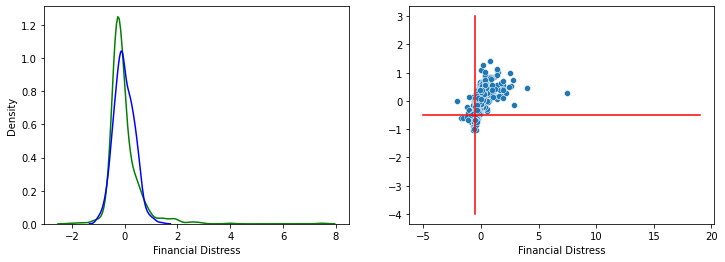

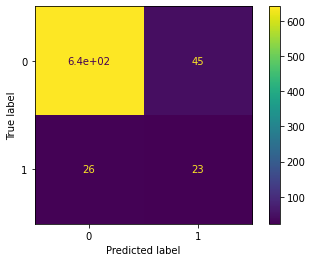

In [ ]:
model = LinearRegression(fit_intercept=False,normalize=True,n_jobs=1,copy_X=True)

evaluation_report(model, 34, 67)

Ridge Regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.0839063649910958, 1.219055073125564
Correclty Classified: 89.93197278911565%
R2 score: 0.3294087621681129
Mean Squared error on Original Data set: 0.249589998411102
Mean Absolute Error: 0.2791748159411453
Max Error: 7.1787003679746615


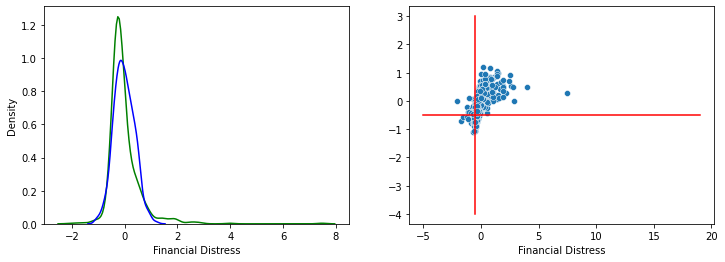

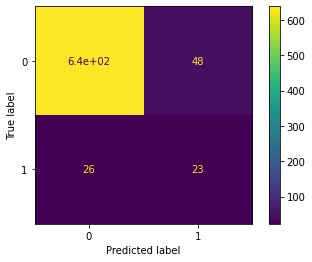

In [ ]:
model = Ridge(alpha=0.01,tol=0.1,solver='saga',copy_X=True,fit_intercept=False)

evaluation_report(model, 34, 67)

Lasso Regression

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.1593731972676113, 0.8799032509310268
Correclty Classified: 91.15646258503402%
R2 score: 0.3262000695611055
Mean Squared error on Original Data set: 0.2507842543713707
Mean Absolute Error: 0.2712113037068642
Max Error: 7.106798156464629


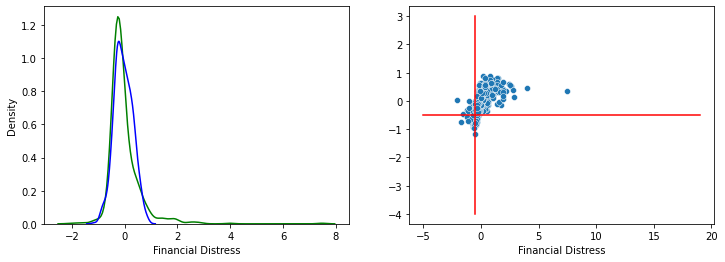

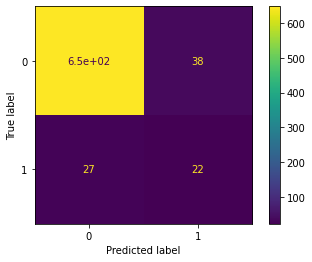

In [ ]:
model = Lasso(alpha=0.01,tol=0.001,selection='random',copy_X=True,fit_intercept=False)

evaluation_report(model, 34, 67)

Elastic Net

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

True Validation set range: -2.0351543918425916, 7.46672097249136
Predicted Validation set range: -1.1403312520396118, 0.9799693725140104
Correclty Classified: 90.88435374149661%
R2 score: 0.33381910980764984
Mean Squared error on Original Data set: 0.24794849372353192
Mean Absolute Error: 0.2699712455304238
Max Error: 7.126677520119003


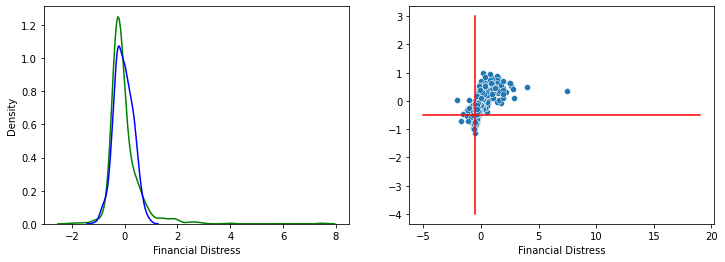

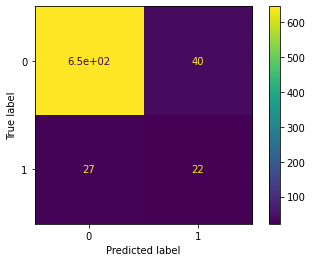

In [ ]:
model = ElasticNet(alpha=0.01, l1_ratio=0.65, copy_X=True, fit_intercept=False, selection='random', tol=0.01)

evaluation_report(model, 34, 67)

In [ ]:
def evaluation_report(model, r1, r2):  
    '''Function that evaluates Trained Model on Validation set'''
    T = df.iloc[:, 0]
    T[(T>=48)] = T.mean()
    X = df.iloc[:, 1:]
#     X= SelectKBest(f_regression, k = 60).fit_transform(X, T)
    X_train, X_test, t_train, t_test = train_test_split(X, T, test_size= 0.2, random_state=r1)

    #X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size= 0.15, random_state=r2)
    model.fit(X_train, t_train)
    y_predict = model.predict(X_test)
    true_val, pred_val = t_test, y_predict
    #od = pd.read_csv('Financial Distress.csv')
    #od['Financial Distress']  
    #true_val = t_val*od['Financial Distress'].std()+od['Financial Distress'].mean()
    #pred_val = y_predict*od['Financial Distress'].std()+od['Financial Distress'].mean()
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    axi = sns.distplot(true_val, hist = False, color = 'g', label = "Actual Value", bins = 20)
    sns.distplot(pred_val, hist = False, color = 'b', label = "Predicted Value", bins = 20, ax= axi)
    print( 'True Validation set range: {}, {}'.format(true_val.min(), true_val.max()))
    print( 'Predicted Validation set range: {}, {}'.format(pred_val.min(), pred_val.max()))
    
    plt.subplot(122)
    sns.scatterplot(true_val, pred_val)
    plt.plot([-0.5]*8, range(-4, 4, 1), 'r')
    plt.plot(range(-5, 20, 1), [-0.5]*25, 'r')
    true_class = copy.deepcopy(true_val); true_class[(true_class>=-0.5)] = 0; true_class[(true_class<-0.5)] = 1
    pred_class = copy.deepcopy(pred_val); pred_class[(pred_class>=-0.5)] = 0; pred_class[(pred_class<-0.5)] = 1
    cm = confusion_matrix(true_class, pred_class)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    print('Correclty Classified: {}%'. format(accuracy_score(true_class, pred_class)*100))
    print('R2 score: {}'.format(r2_score(t_test, y_predict)))
    print('Mean Squared error on Original Data set: {}'.format(mean_squared_error(true_val, pred_val)))
    print('Mean Absolute Error: {}'.format(mean_absolute_error(true_val, pred_val)))
    print('Mean Absolute Percent Error: {}'.format(mean_absolute_percentage_error(true_val, pred_val)))
    print('Max Error: {}'.format(max_error(true_val, pred_val)))
    

In [ ]:
decision = DecisionTreeRegressor(max_depth=7 , splitter= 'best' , max_leaf_nodes=15 , criterion= 'friedman_mse'
                              )
evaluation_report(decision,15,15)

In [ ]:
random = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=5, max_features=10)
evaluation_report(random , 15 , 15)

In [ ]:
extra_tree = ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=25,
                            min_samples_leaf=35)
evaluation_report(extra_tree , 15 , 15)